## Acknowledgement

This notebook is based on the book **["Build a Large Language Model (From Scratch)"](https://www.manning.com/books/build-a-large-language-model-from-scratch)** by **Sebastian Raschka**, published by Manning Publications.

- [Book on Manning](https://www.manning.com/books/build-a-large-language-model-from-scratch)
- [GitHub Repository](https://github.com/rasbt/LLMs-from-scratch)

---

# **Chapter 6: Fine-tuning for classification**

# Fine-tuning for Classification

### **Accessing Google Drive in Google Colab**

When working in Google Colab, we often need to store and access datasets, models, or other files. Since Colab runs on a virtual machine, files stored on our local computer are not directly accessible. To solve this, Google Colab allows us to mount your Google Drive, enabling seamless access to our stored files.

The code below mounts Google Drive so that we can access its files and directories directly within Colab.This allows us to read, write, and manage files stored in your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now that we have **mounted Google Drive** in Google Colab, the next step is to **navigate to a specific folder** where our project files are stored. Since Colab starts in the **default working directory** (`/content/`), we need to **change it to our desired location** inside Google Drive.

The code below changes the current working directory to **a specific project folder** in Google Drive and prints the new path to confirm the change.

In [2]:
import os
os.chdir('/content/drive/MyDrive/LLM from Scratch/chapter_6')
print(os.getcwd())

/content/drive/MyDrive/LLM from Scratch/chapter_6


The code below **sets up Colab to properly display images and plots** within the notebook. This is especially useful when working with **matplotlib visualizations, charts, and model-generated images**.

In [3]:
from IPython.display import Image, display
%matplotlib inline

In this chapter, we will fine-tune LLM on a specific task of classifying text. We will classify text as either `"spam"` or `"not spam"`. Two main ways of fine-tuning LLM are: fine-tuning for classifying text and fine-tuning for following instructions.

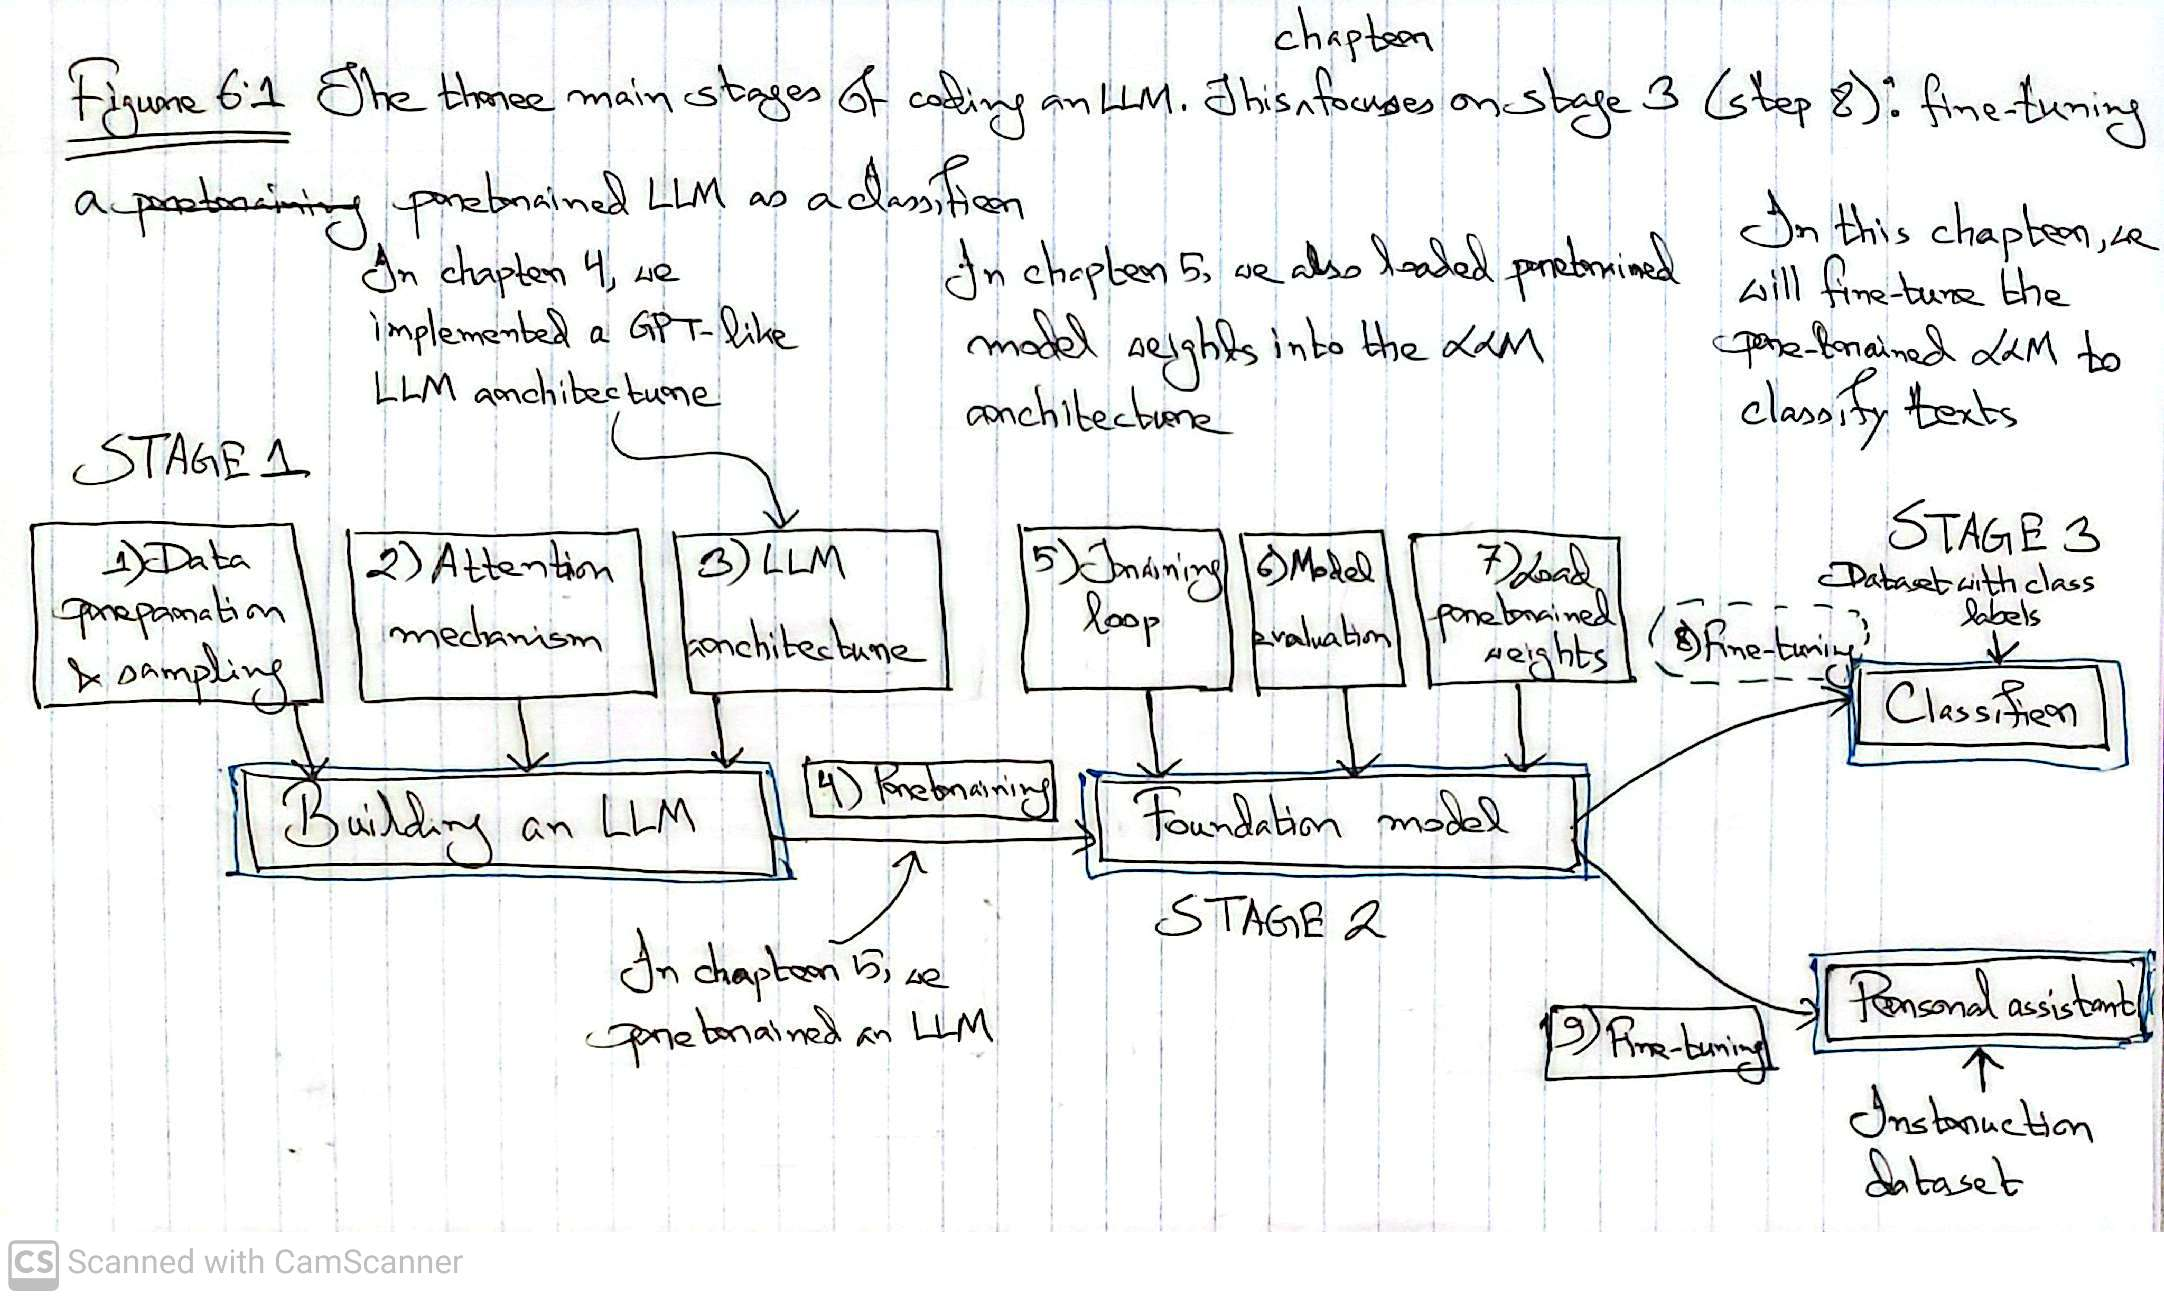

In [4]:
display(Image(filename='6_1.jpg', width=800))

## **Different categories of fine-tuning**

**Instruction fine-tuning** and **classification fine-tuning** are the most common ways to fine-tune language models.

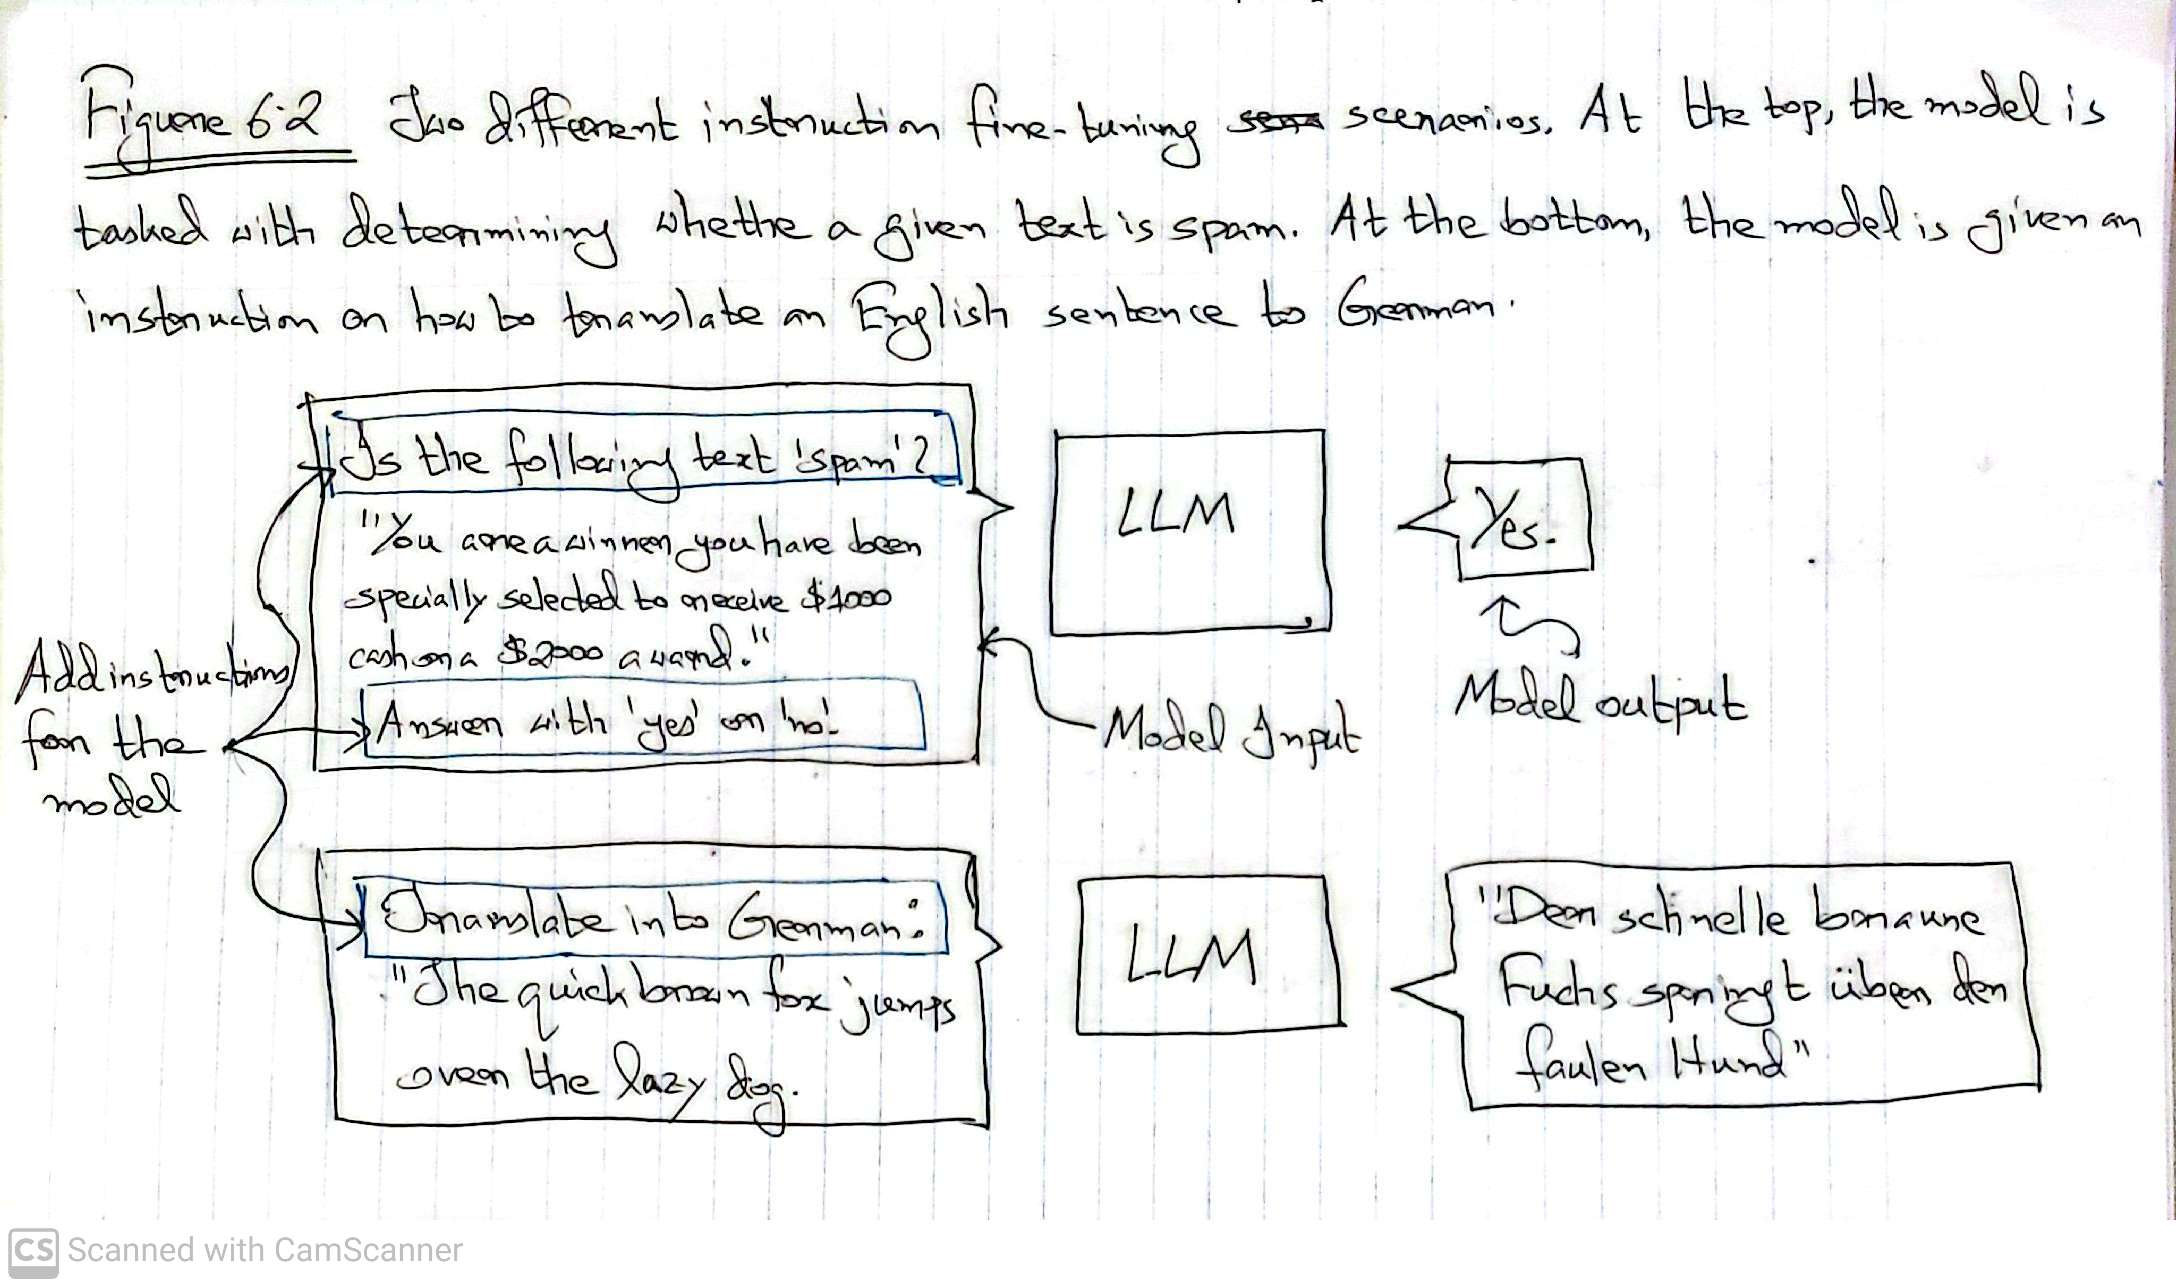

In [5]:
display(Image(filename='6_2.jpg', width=800))

In **instruction fine-tuning**, a language model is trained on a set of tasks using sepcific instructions descrined in natural language prompts.

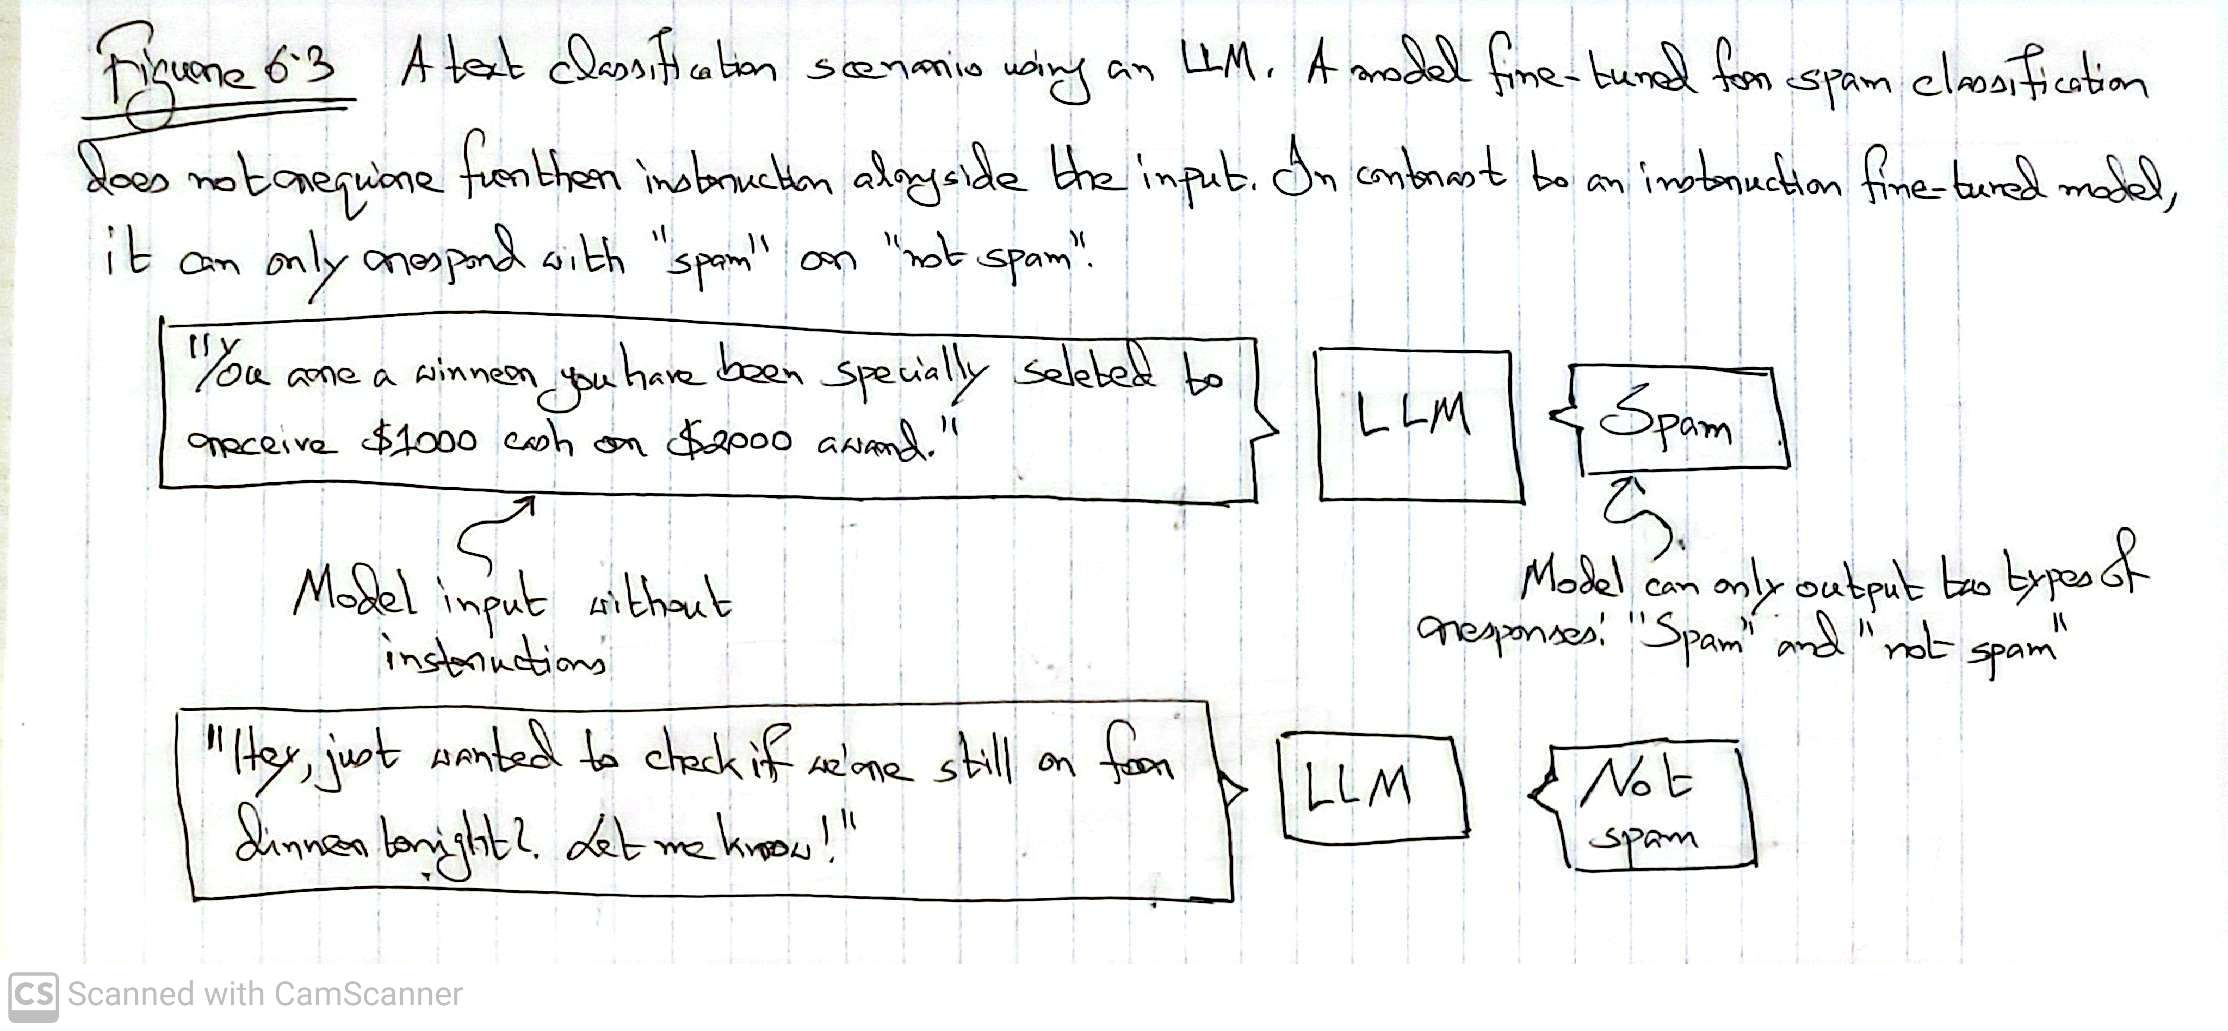

In [6]:
display(Image(filename='6_3.jpg', width=800))

 In **classification fine-tuning**, the model is trained to recognize a specific set of class labels, such as "spam" and "not spam" (look at the figure above).

## **Preparing the dataset**

First, we download and prepare the dataset. We will work with a text message dataset consisting of spam and non-spam mesages.

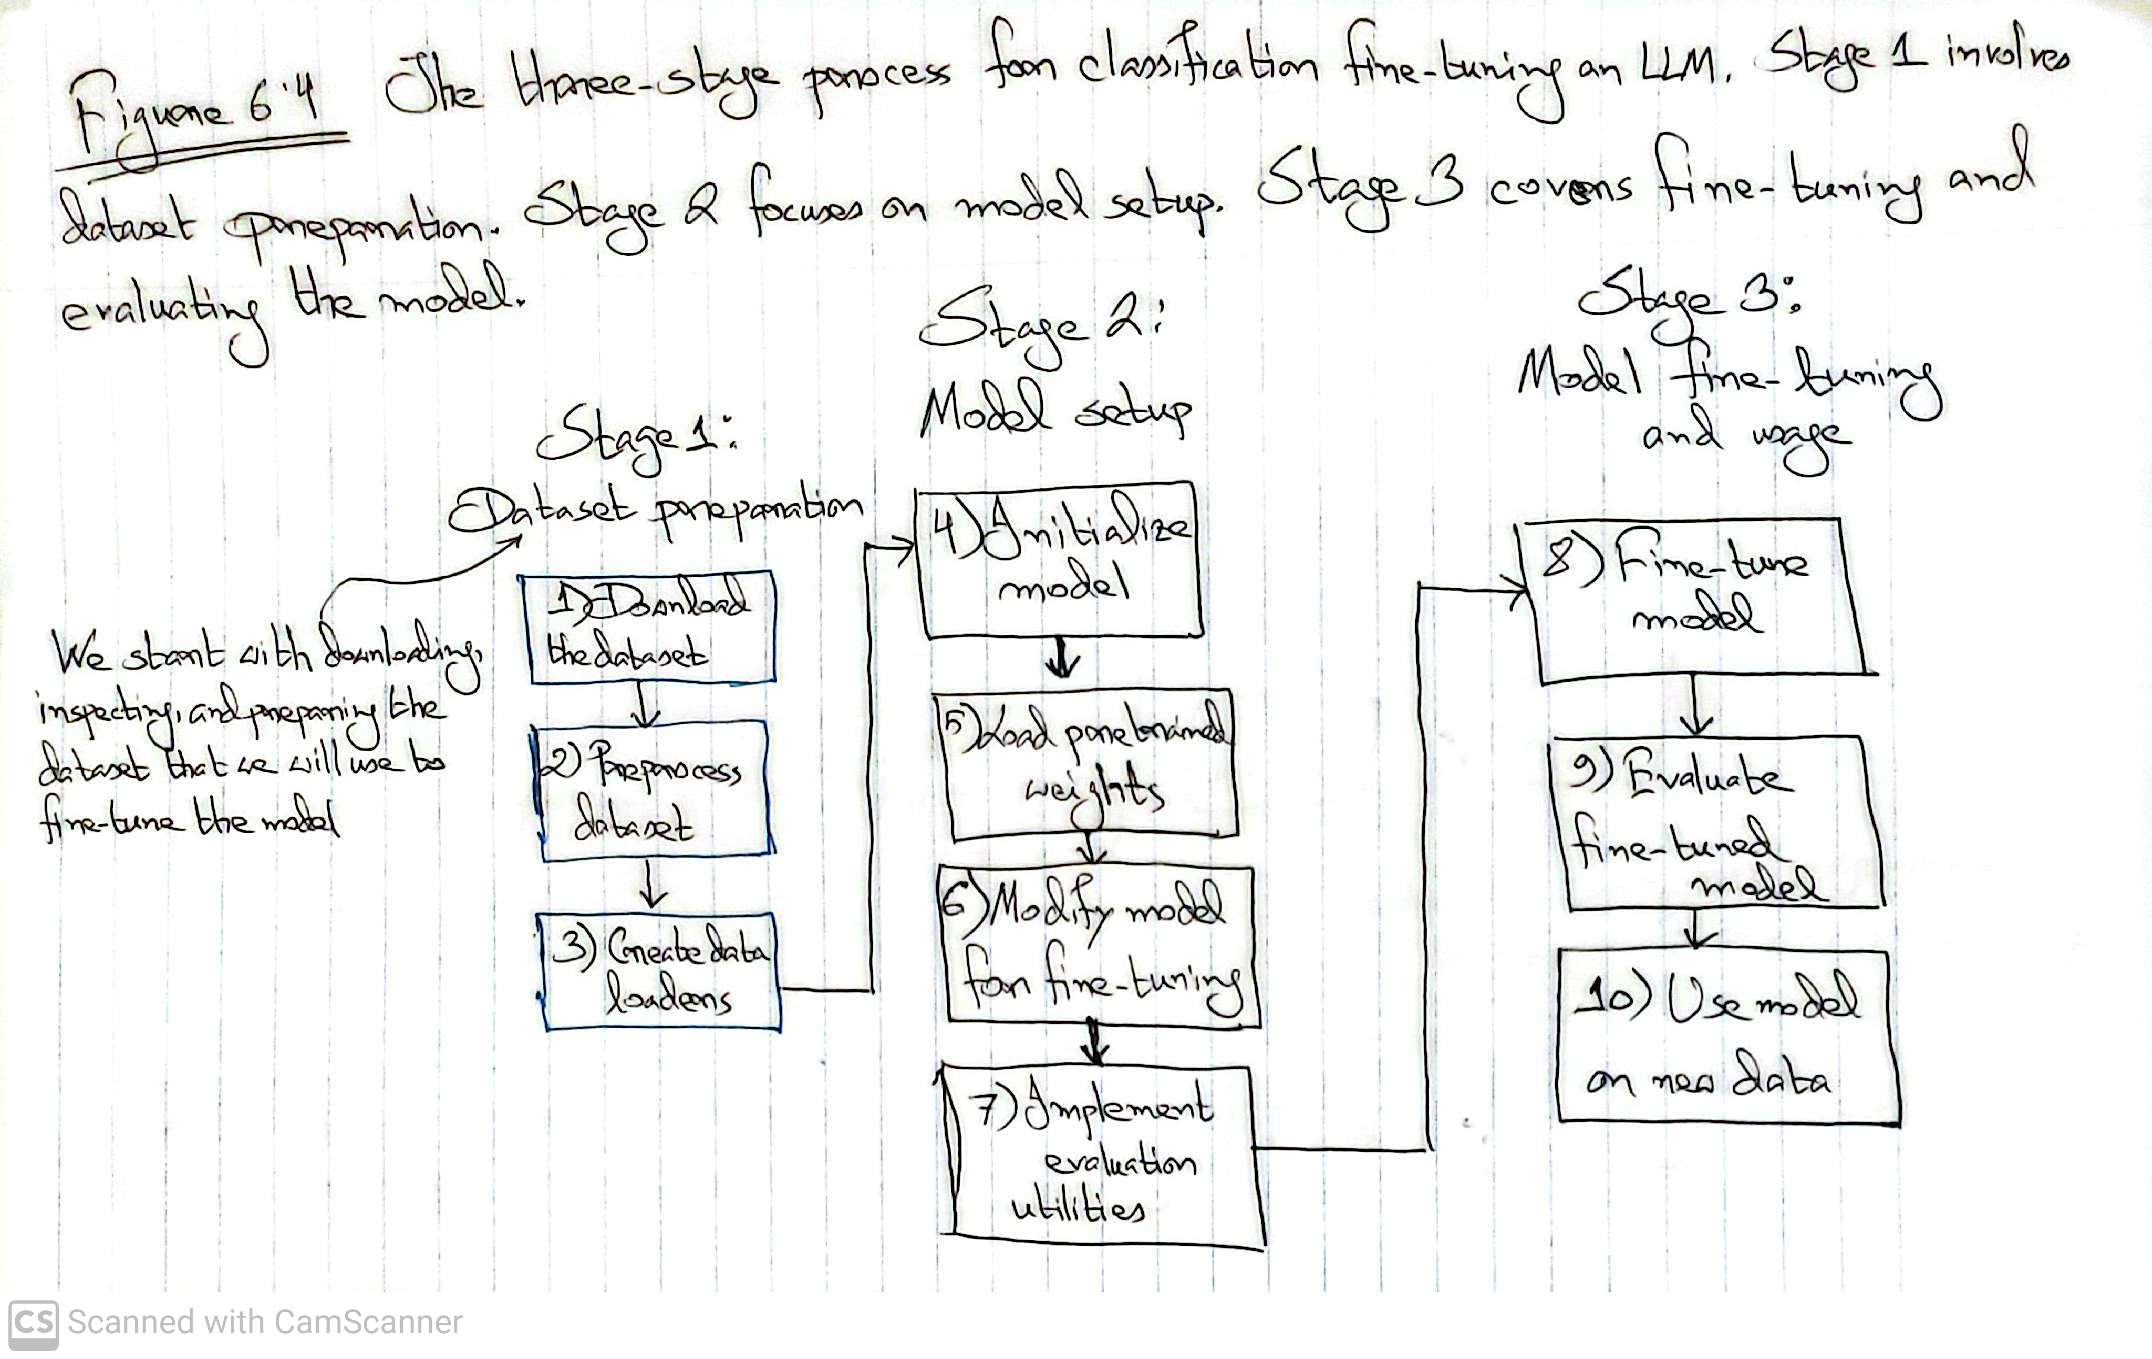

In [8]:
display(Image(filename='6_4.jpg', width=800))

### **Downloading and unzipping the dataset**

Before training a spam classifier, we need a **dataset of SMS messages labeled as spam or not spam**. This script automates the **downloading**, **extracting**, and **renaming** of the SMS Spam Collection dataset from the **UCI Machine Learning Repository**.

The code below ensures that the dataset is **properly formatted and ready for analysis or training**.

What This Code Does

- ✅ Downloads the dataset from a publicly available URL.
- ✅ Extracts the ZIP file containing the SMS spam messages.
- ✅ Renames the extracted file to use a .tsv extension for clarity.
- ✅ Avoids redundant downloads by checking if the dataset already exists.

In [9]:
import urllib.request  # Used to download the file from the internet
import zipfile  # Used to extract the contents of the ZIP file
import os  # Provides file handling operations like renaming files
from pathlib import Path  # Used for handling file paths in a more intuitive way

# URL of the dataset (ZIP file) that needs to be downloaded
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"

# Path where the downloaded ZIP file will be saved
zip_path = "sms_spam_collection.zip"

# Directory where the ZIP file will be extracted
extracted_path = "sms_spam_collection"

# Final path where the extracted file will be stored (renamed with .tsv extension)
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    """
    This function downloads a ZIP file containing SMS spam data, extracts it,
    and renames the extracted file to have a .tsv extension.
    """

    # Check if the extracted file already exists to avoid redundant downloads
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return  # Exit the function early if the file is already present

    # Download the ZIP file from the URL
    with urllib.request.urlopen(url) as response:  # Open the URL
        with open(zip_path, "wb") as out_file:  # Open the file in binary write mode
            out_file.write(response.read())  # Read from the URL and write to the file

    # Extract the contents of the downloaded ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:  # Open the ZIP file in read mode
        zip_ref.extractall(extracted_path)  # Extract all files to the specified directory

    # The extracted file does not have a proper extension. Locate it.
    original_file_path = Path(extracted_path) / "SMSSpamCollection"

    # Rename the extracted file to include a .tsv extension for clarity
    os.rename(original_file_path, data_file_path)

    print(f"File downloaded and saved as {data_file_path}")


# Call the function to execute the download and extraction process
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


### Load the dataset

Once we have downloaded and prepared the **SMS Spam Collection** dataset, the next step is to **load it into a structured format** so we can analyze and manipulate it efficiently.

This script **uses Pandas to read the dataset into a DataFrame**, allowing us **to view and work with the data** in a tabular format.

What This Code Does
- ✅ Loads the SMS spam dataset from a .tsv (tab-separated values) file.
- ✅ Assigns column names manually since the dataset doesn’t include a header row.
- ✅ Displays the dataset so we can inspect its structure and contents.

In [10]:
import pandas as pd  # Import the pandas library, which is used for data manipulation and analysis

# Read the dataset from the specified file path
df = pd.read_csv(
    data_file_path,  # The path to the TSV file that contains the SMS spam data
    sep='\t',  # The file uses tab (`\t`) as the separator instead of a comma (`,`)
    header=None,  # There is no header row in the file, so we explicitly tell pandas not to treat any row as a header
    names=["Label", "Text"]  # Assign custom column names: "Label" for spam/ham, "Text" for the message content
)

# Display the dataframe to inspect its contents
df

Label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

Before diving into **training a spam classification model**, it's crucial to **understand the distribution of labels in our dataset**. The code below **counts and displays the number of spam and non-spam (ham) messages** in the dataset.

In [11]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


Since our dataset has **4825 non-spam (ham) messages** and only **747 spam messages**, it is **imbalanced**. Training a model on such data could lead to **bias towards the majority class (ham)**.

To address this, we use **undersampling**, a technique where we **randomly select a subset of the majority class (ham) to match the minority class (spam)**. This ensures that both classes have an **equal number of samples (747 each)**, making the dataset balanced.

The code below **creates a balanced dataset** by **undersampling ham messages** to **match the spam message count**.

Now, we want to undersample and sample 747 instances from each class.

In [12]:
def create_balanced_dataset(df):
  num_spam = df[df['Label'] == "spam"].shape[0]
  ham_subset = df[df['Label'] == "ham"].sample(num_spam, random_state=42)
  balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
  return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


Now, convert the class labels "ham" and "spam" into class levels 0 and 1, respectively.

In [13]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

Now, create a function `random_split` to split the dataset into three parts, 70% for training, 10% for validation, and 20% for testing.

In [14]:
def random_split(df, train_frac, validation_frac):
    """
    This function takes a DataFrame and splits it into three parts:
    - Training set
    - Validation set
    - Test set

    The function first shuffles the DataFrame randomly to ensure a good mix of data points.
    Then, it uses the specified fractions to determine how much data should go into
    the training, validation, and test sets.

    Parameters:
    - df (DataFrame): The dataset to be split.
    - train_frac (float): The fraction of the dataset to use for training (e.g., 0.7 for 70%).
    - validation_frac (float): The fraction of the dataset to use for validation (e.g., 0.1 for 10%).

    Returns:
    - train_df (DataFrame): The training set.
    - validation_df (DataFrame): The validation set.
    - test_df (DataFrame): The test set (remaining data).
    """

    # Shuffle the dataset to randomize the order of rows.
    # This prevents any unintended patterns from affecting model performance.
    df = df.sample(
        frac=1,  # `frac=1` means we keep all rows but shuffle their order
        random_state=123  # Setting a random seed ensures reproducibility
    ).reset_index(drop=True)  # Reset index after shuffling to keep it clean

    # Calculate the index where the training data should end.
    # Multiply the total number of rows by the fraction for training.
    train_end = int(len(df) * train_frac)

    # Calculate the index where the validation data should end.
    # The validation fraction is added to the training fraction to determine this boundary.
    validation_end = train_end + int(len(df) * validation_frac)

    # Slice the DataFrame into three parts:
    # - From start to `train_end` → Training set
    train_df = df[:train_end]

    # - From `train_end` to `validation_end` → Validation set
    validation_df = df[train_end:validation_end]

    # - From `validation_end` to the end → Test set
    test_df = df[validation_end:]

    # Return the three data subsets
    return train_df, validation_df, test_df


# Call the function to split the dataset `balanced_df` into training, validation, and test sets.
train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1  # 70% for training, 10% for validation, remaining 20% for testing
)

Now, we save this dataset.

In [15]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Creating data loaders

Previously, we used sliding window technique to generate uniformly sized text chunks which we then batched. In this chapter, spam dataset has text messages of varying lengths. To batch these messages, we will pad all messages to the length of the longest message in the dataset or batch.

Now, we will add the token ID of text `"<|endoftext|>"` as padding tokens to all shorter messages. `50256` is the token ID of the padding token `"<|endoftext|>"`.

In [16]:
!pip install tiktoken

In [17]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


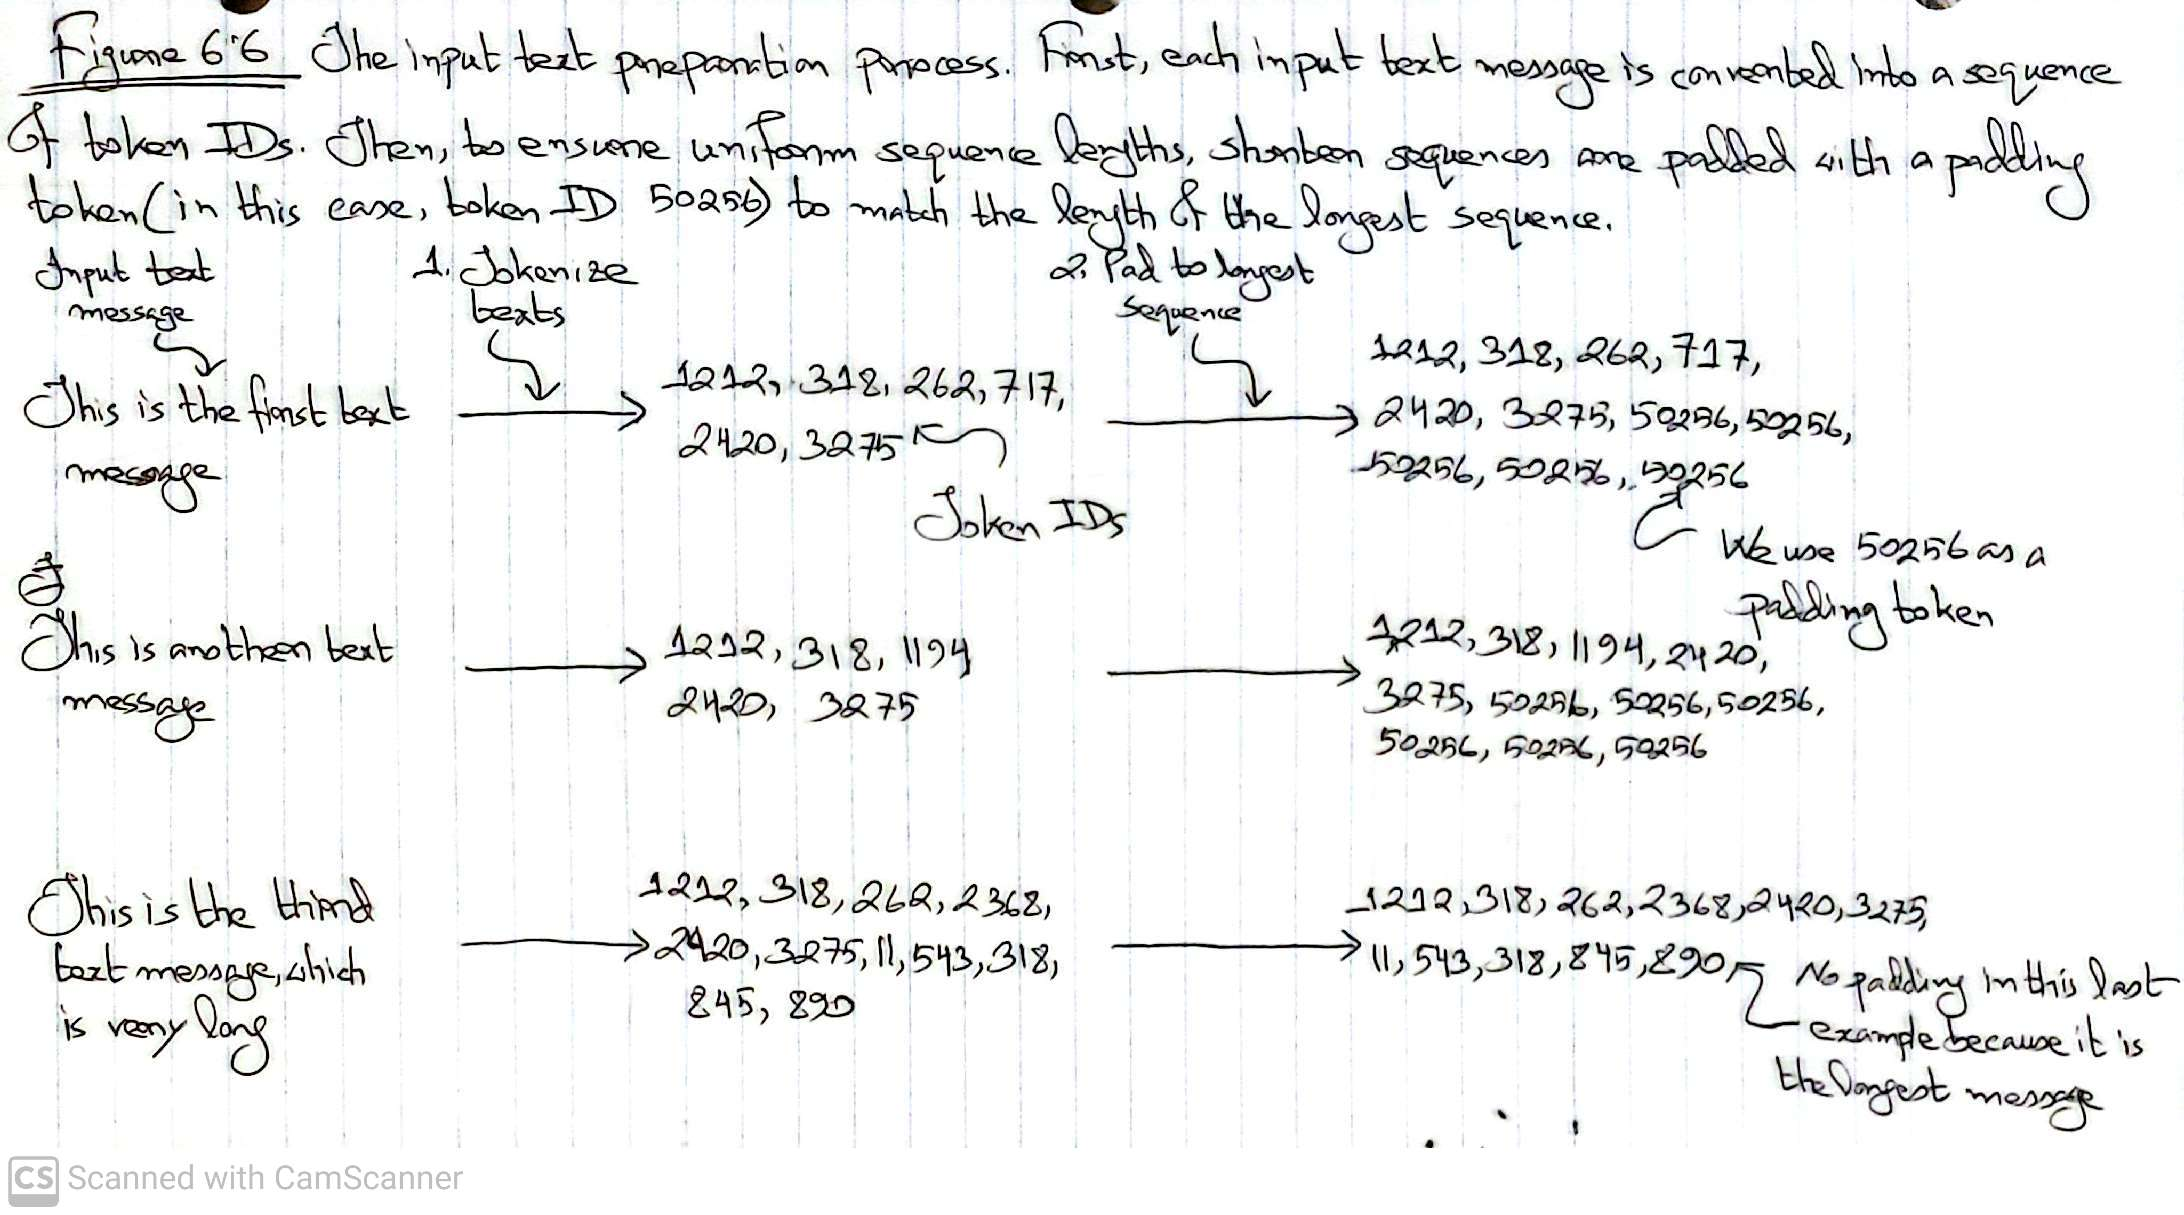

In [18]:
display(Image(filename='6_6.jpg', width=800))

### Pytorch Dataset class

Before instantiating the data loaders, we need to implement a PyTorch `Dataset` that specifies how the data is loaded and processed. The `SpamDataset` class encodes the text message into token sequences, finds out the longest sequence in the training dataset, pads smaller sequence to match the length of the longest sequence.

In [19]:
import torch  # Import PyTorch, a library used for deep learning.
from torch.utils.data import Dataset  # Import Dataset class to create a custom dataset.
import pandas as pd  # Import pandas, a library used for handling CSV files and tabular data.

class SpamDataset(Dataset):  # Define a custom dataset class that extends PyTorch's Dataset class.
  def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
    """
    Initializes the dataset by reading text data, tokenizing it, padding or truncating sequences, and assigning labels.

    Args:
      csv_file (str): Path to the CSV file containing the dataset.
      tokenizer (object): Tokenizer that converts text into a list of tokenized numerical values.
      max_length (int, optional): Maximum sequence length. If None, it will be automatically determined.
      pad_token_id (int, optional): Token ID used for padding shorter sequences. Default is 50256.
    """

    # Read the CSV file into a pandas DataFrame (a structured table-like format).
    self.data = pd.read_csv(csv_file)

    # Tokenize each text sample in the "Text" column and store the numerical representations in a list.
    # tokenizer.encode(text) converts each text string into a list of integers (tokens).
    self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]

    # If max_length is not provided (i.e., None), determine the maximum sequence length in the dataset.
    if max_length is None:
      self.max_length = self._longest_encoded_length()  # Calls a helper function to find the longest sequence.
    else:
      self.max_length = max_length  # Otherwise, set max_length to the given value.
      # If a sequence is longer than max_length, truncate it (cut off the extra tokens).
      self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

    # Pad all sequences to the same length (max_length).
    # If a sequence is shorter than max_length, append pad_token_id (default 50256) to fill the gap.
    self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts]

  def __getitem__(self, index):
    """
    Retrieves a single sample (input text and label) from the dataset.

    Args:
      index (int): The index of the sample to retrieve.

    Returns:
      tuple: (tokenized text as a PyTorch tensor, label as a PyTorch tensor)
    """

    # Get the tokenized and padded sequence at the given index.
    encoded = self.encoded_texts[index]

    # Retrieve the corresponding label from the "Label" column in the dataset.
    label = self.data.iloc[index]["Label"]

    # Convert both the tokenized text and label into PyTorch tensors.
    return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))

  def __len__(self):
    """
    Returns the total number of samples in the dataset.

    Returns:
      int: The number of rows (text samples) in the dataset.
    """
    return len(self.data)

  def _longest_encoded_length(self):
    """
    Determines the length of the longest tokenized sequence in the dataset.

    Returns:
      int: Maximum tokenized sequence length in the dataset.
    """

    # Initialize max_length to 0 (starting value).
    max_length = 0

    # Iterate over all tokenized sequences to find the longest one.
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)  # Get the number of tokens in the current sequence.
      if encoded_length > max_length:  # If this sequence is longer than the previously found max_length,
        max_length = encoded_length  # Update max_length to this new value.

    return max_length  # Return the length of the longest tokenized sequence.


In [20]:
train_dataset = SpamDataset(csv_file="train.csv", max_length=None, tokenizer=tokenizer)

In [21]:
print(train_dataset.max_length)

120


In [ ]:
# print(train_dataset.encoded_texts[0])

Now, we ensure that the validation and test sets match the length of the longest training sequence.

In [22]:
val_dataset = SpamDataset(csv_file="validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset(csv_file="test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

Now, we can instantiate the data loaders. Here, the targets are class labels. If our batch size is 8, then each batch will have training examples of length 120 and the corresponding class labels as shown in the figure below.

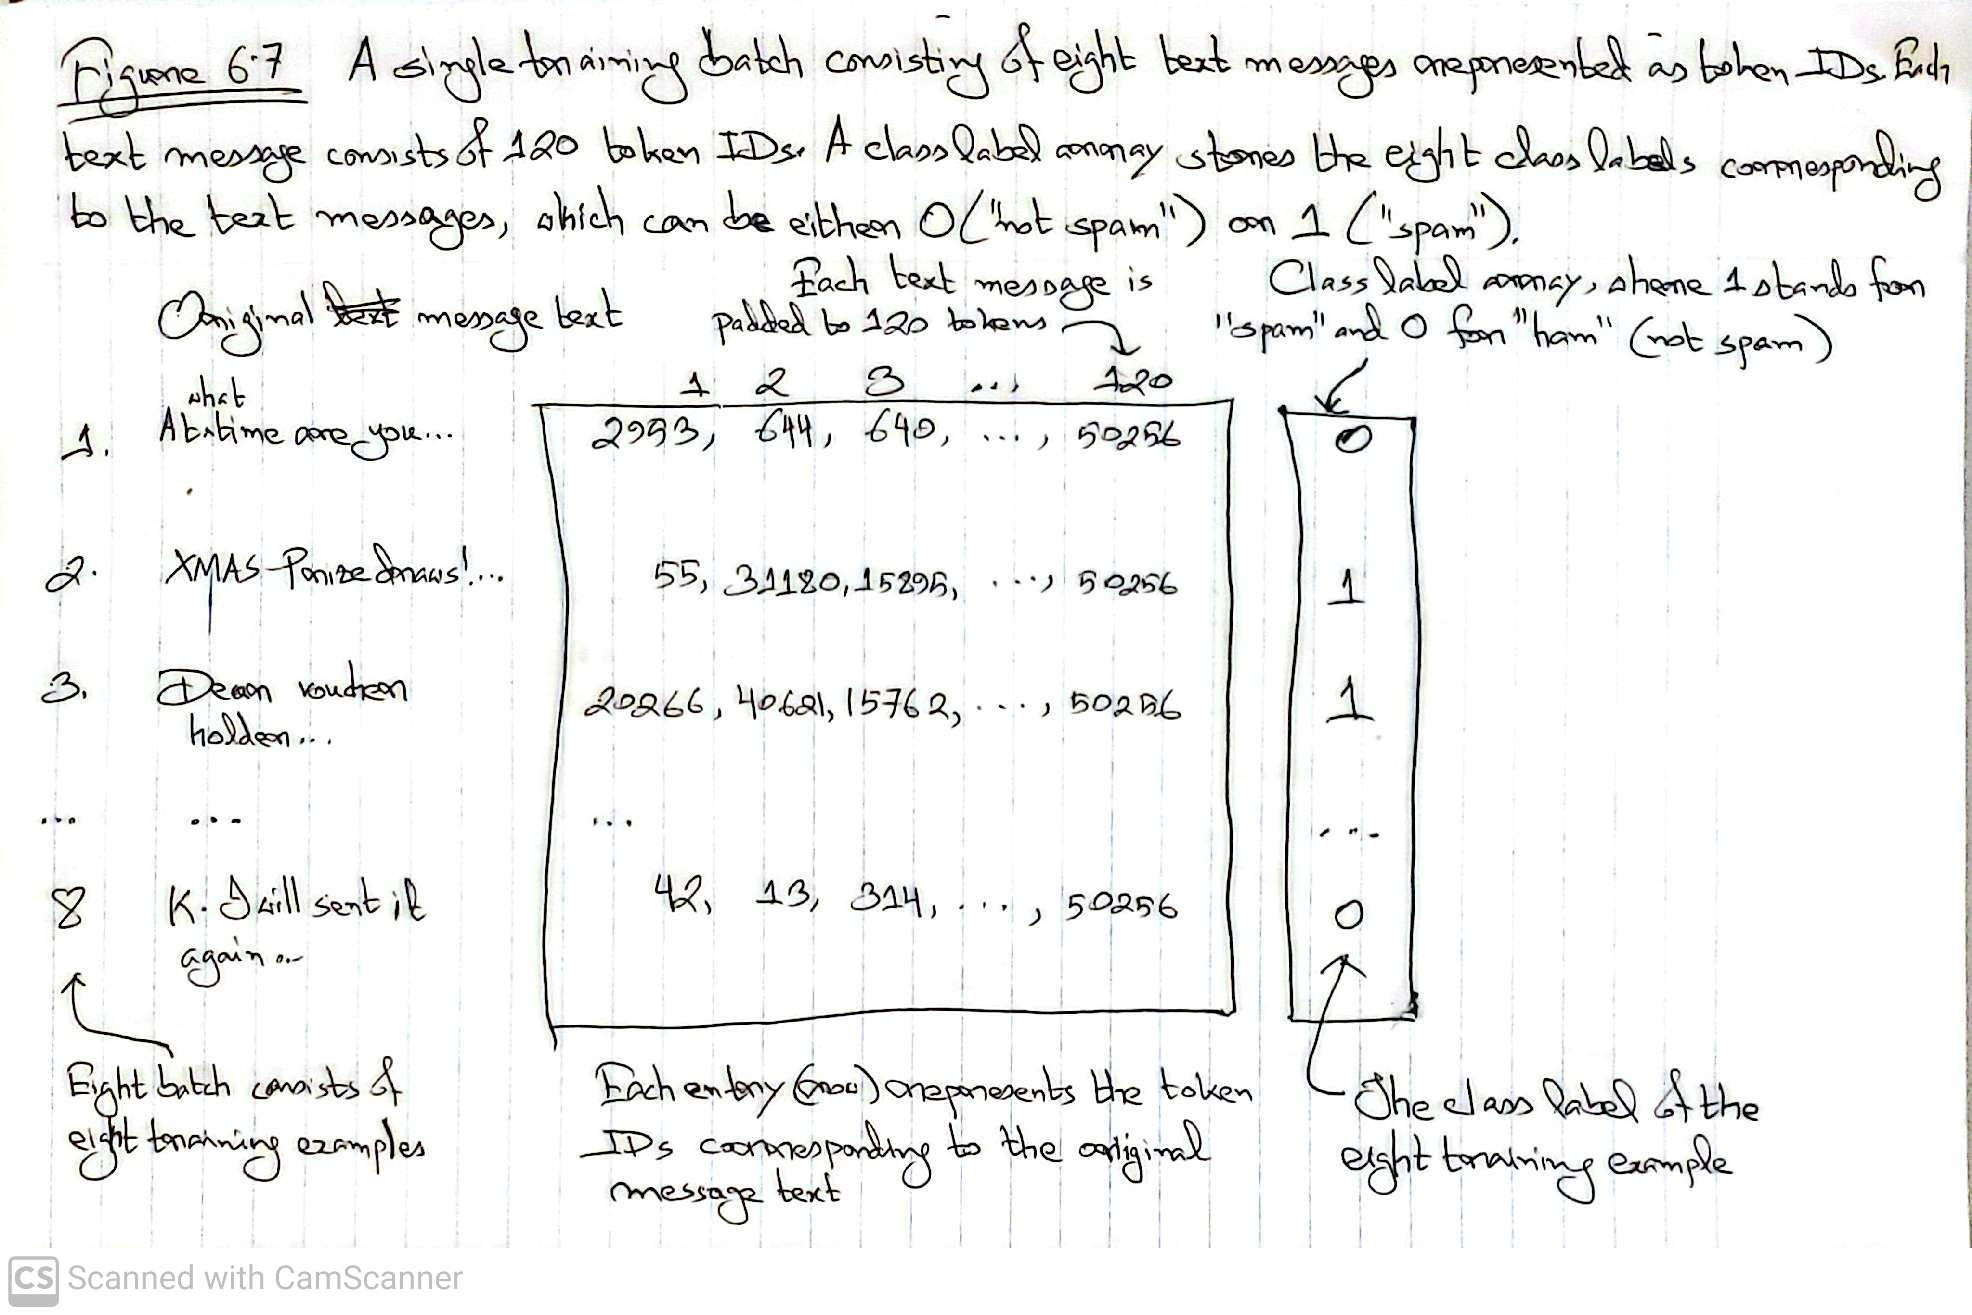

In [23]:
display(Image(filename='6_7.jpg', width=800))

### Creating PyTorch data loaders

In [24]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=False)

#### **Why is drop_last=False for val_loader and test_loader?**
- The drop_last argument in PyTorch's DataLoader determines whether to drop the last batch if it is smaller than batch_size.
- When drop_last=True, the last incomplete batch (if the dataset size is not perfectly divisible by the batch size) is discarded.
- When drop_last=False, the last batch is included, even if it contains fewer samples than the specified batch_size.

For **validation** (`val_loader`) and **testing** (`test_loader`), `drop_last=False` is used because:

1. **We need to evaluate on all available data**: Dropping some samples would mean that certain examples are never evaluated, leading to biased validation/testing results.
2. **Validation/Test sets are typically used for inference**: Unlike training, where batch size consistency is crucial for certain optimizations (like Batch Normalization), validation and test phases do not require strict batch sizes.

For **training** (`train_loader`), `drop_last=True` is often set because:

- Some models, especially those using **Batch Normalization** or **Layer Normalization**, expect consistent batch sizes during training.
- Dropping the last batch helps maintain stable gradients, which is especially useful when using mini-batch optimization techniques like **SGD**.

Iterating over the train_loader in the loop and then printing the tensor dimensions after exiting the loop ensures that we capture the shape of the last batch. However, if the dataset size is not perfectly divisible by batch_size and drop_last=True, every batch (except potentially the last one) will have the same shape.

**Why Iterate?**
1. **To Get the Last Batch**: If `drop_last=False`, the last batch might have fewer samples than batch_size, so iterating ensures we print its actual shape.
2. **To Load Data Properly**: `train_loader` is an iterator, meaning batches are only created when iterated over. Unlike simple lists, calling `train_loader` directly does not return a batch—it returns a DataLoader object, which must be iterated to access batches.
3. **Lazy Loading**: PyTorch's DataLoader loads batches dynamically, meaning data is not preloaded when you create the DataLoader object. Iterating ensures the batches are actually materialized.

In [25]:
for input_batch, target_batch in train_loader:
  pass
print("Input data dimensions:", input_batch.shape)
print("Label data dimensions:", target_batch.shape)

Input data dimensions: torch.Size([8, 120])
Label data dimensions: torch.Size([8])


As we have `drop_last=True` in the `train_loader`, every batch will have the same size and so first should have the same size as we got the batch size for the last batch in the code above.

In [26]:
input_batch, target_batch = next(iter(train_loader))
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])


In [27]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


**Now, we need to prepare the model for fine-tuning.**

## **Initializing a model with pretrained weights**

Initialize our pretrained model.

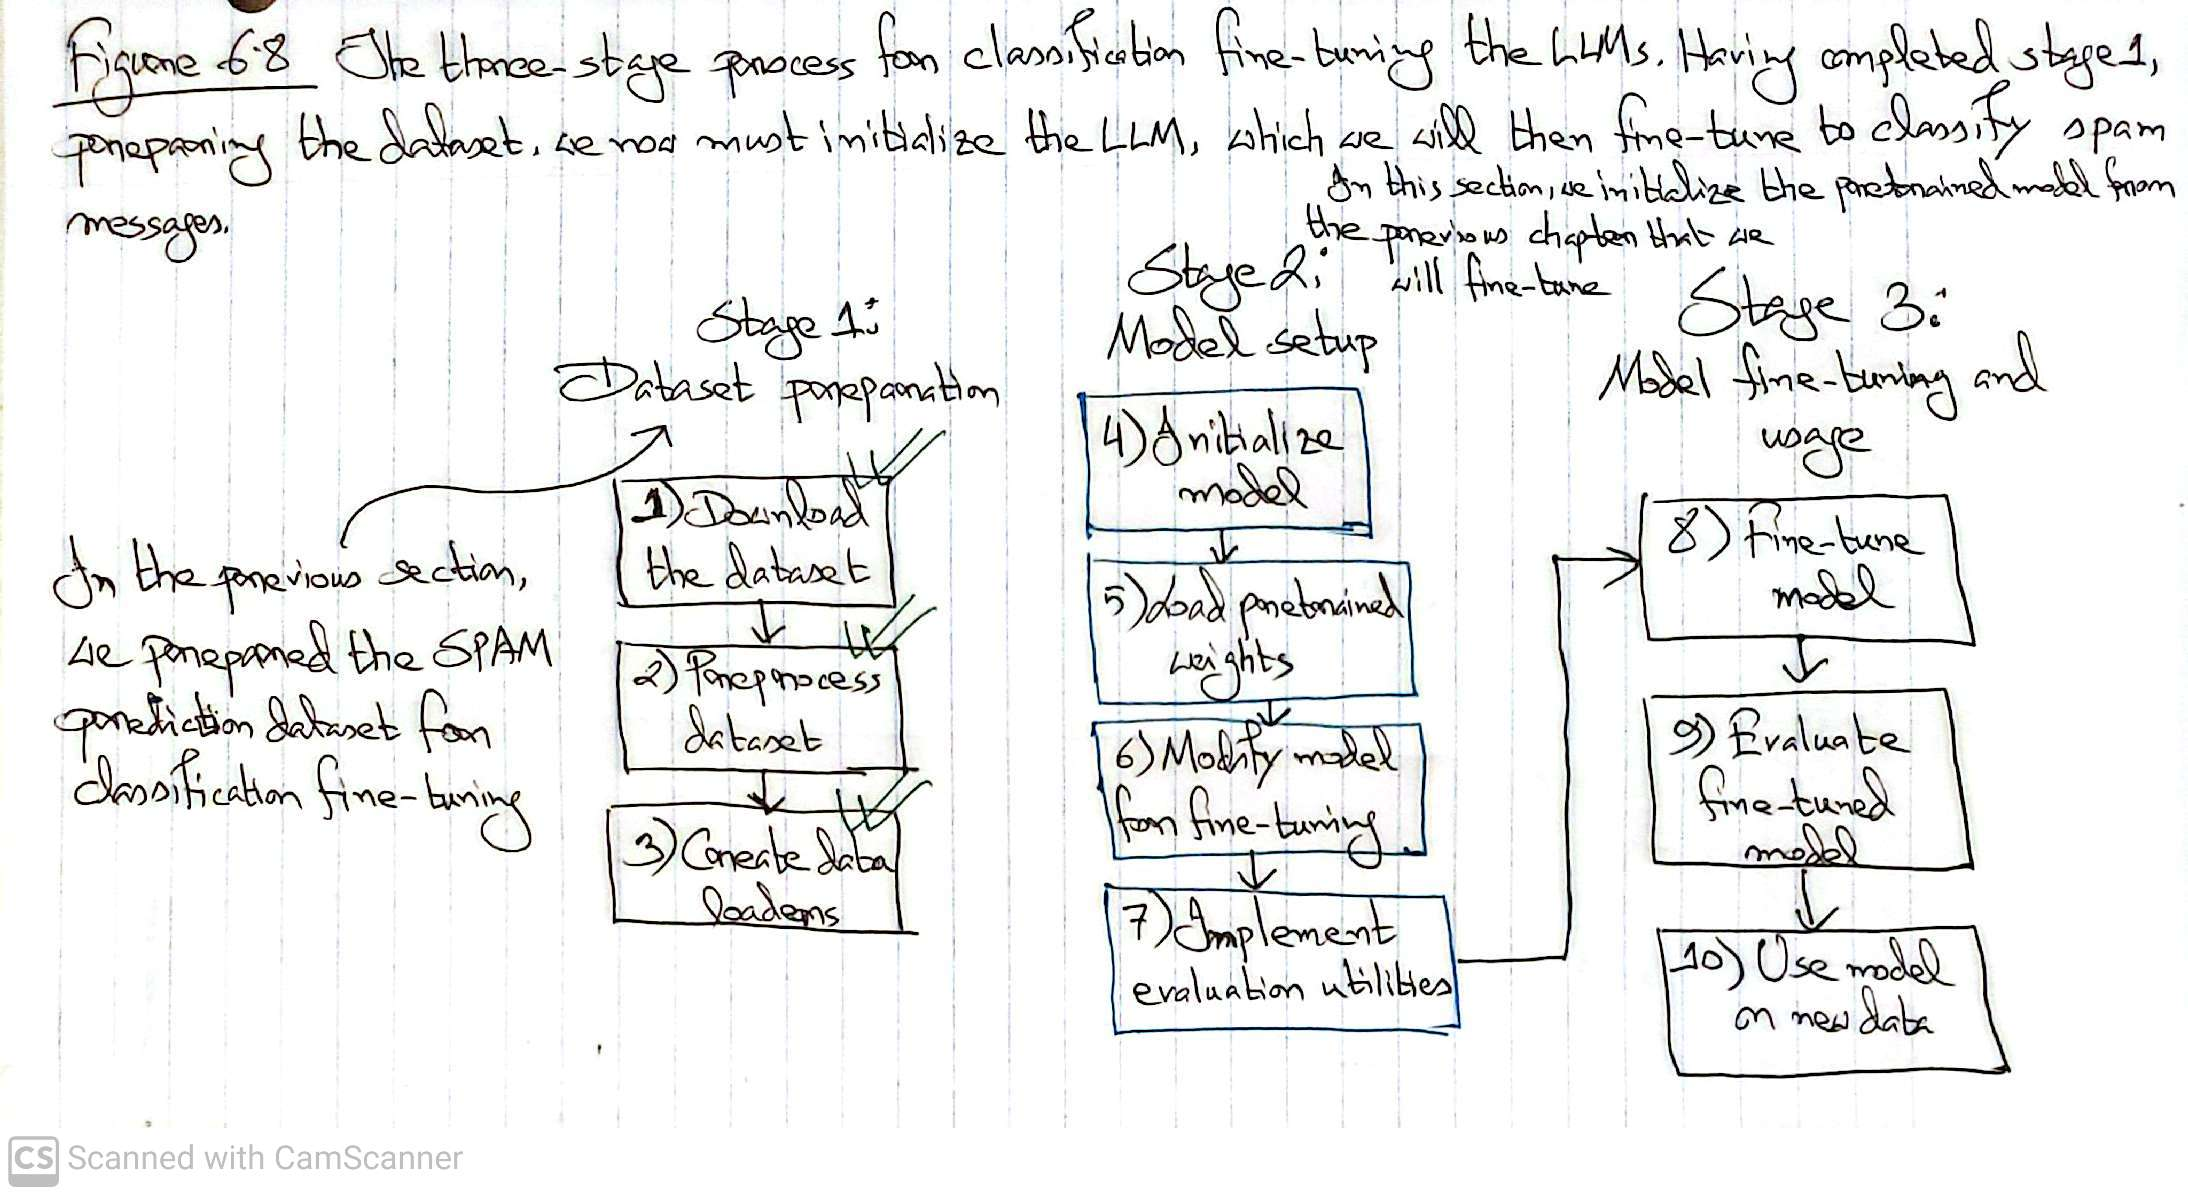

In [28]:
display(Image(filename='6_8.jpg', width=800))

In [29]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [30]:
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12}

## Loading a pretrained GPT model

Now, load all the functions needed to load the GPT-2 model, that we wrote before in earlier chapters.

In [31]:
import numpy as np

In [32]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, "
    "Right: {right.shape}"
    )
  return torch.nn.Parameter(torch.tensor(right))

In [33]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])


### **Import the GPT model**.

In [34]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdims=True)
    var = x.var(dim=-1, keepdims=True, unbiased=False) # unbiased=False results in the division by n instead of n-1
    # Dividing by n-1 is known as Bessel's correction. So, we have biased estimate of variance.
    # GPT-2 was implemented using Tensorflow that used this approach. Also for LLMs, the difference between
    # n and n-1 is practically negligible.
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *
                                     (x + 0.044715 * torch.pow(x, 3))
                                     ))

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # Ensure that d_out is divisible by num_heads so each head has equal dimensions
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"

        self.d_out = d_out  # Output dimensionality (total for all heads combined)
        self.num_heads = num_heads  # Number of attention heads
        self.head_dim = d_out // num_heads  # Dimensionality of each head

        # Linear layers to project input into queries, keys, and values
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)  # Project input to query space
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)    # Project input to key space
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)  # Project input to value space

        # Final linear layer to combine the results of all heads
        self.out_proj = nn.Linear(d_out, d_out)

        # Dropout layer for regularization to prevent overfitting
        self.dropout = nn.Dropout(dropout)

        # Upper triangular mask to prevent attention to future tokens (causality)
        # Shape: (context_length, context_length)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        """
        x: Input tensor of shape (batch_size, num_tokens, d_in)
        """
        b, num_tokens, d_in = x.shape  # Extract batch size, number of tokens, and input dimensions

        # Project input x into queries, keys, and values
        keys = self.W_key(x)        # Shape: (batch_size, num_tokens, d_out)
        queries = self.W_query(x)  # Shape: (batch_size, num_tokens, d_out)
        values = self.W_value(x)   # Shape: (batch_size, num_tokens, d_out)

        # Split d_out into num_heads and head_dim for multi-head attention
        # Reshape keys, values, and queries to include a num_heads dimension
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       # Shape: (batch_size, num_tokens, num_heads, head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)   # Shape: (batch_size, num_tokens, num_heads, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) # Shape: (batch_size, num_tokens, num_heads, head_dim)

        # Transpose num_tokens and num_heads for easier computation across heads
        keys = keys.transpose(1, 2)       # Shape: (batch_size, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2) # Shape: (batch_size, num_heads, num_tokens, head_dim)
        values = values.transpose(1, 2)   # Shape: (batch_size, num_heads, num_tokens, head_dim)

        # Compute scaled dot-product attention scores
        # Multiplying queries with keys (transposed) along head_dim
        attn_scores = queries @ keys.transpose(2, 3)  # Shape: (batch_size, num_heads, num_tokens, num_tokens)

        # Apply the causality mask to prevent attention to future tokens
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Mask for current sequence length
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # Set masked positions to negative infinity

        # Normalize attention scores using softmax along the last dimension (num_tokens)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)  # Shape: (batch_size, num_heads, num_tokens, num_tokens)

        # Apply dropout for regularization
        attn_weights = self.dropout(attn_weights)

        # Compute context vectors by multiplying attention weights with values
        context_vec = (attn_weights @ values)  # Shape: (batch_size, num_heads, num_tokens, head_dim)

        # Transpose back to original layout to combine the heads
        context_vec = context_vec.transpose(1, 2)  # Shape: (batch_size, num_tokens, num_heads, head_dim)

        # Flatten the multi-head output by merging num_heads and head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  # Shape: (batch_size, num_tokens, d_out)

        # Final linear layer to combine information across heads
        context_vec = self.out_proj(context_vec)  # Shape: (batch_size, num_tokens, d_out)

        return context_vec

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(d_in=cfg["emb_dim"], d_out=cfg["emb_dim"], context_length=cfg["context_length"],
                                  num_heads=cfg["n_heads"], dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):

    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x

class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

### **Loading a pretrained GPT model**

In [35]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch


import os
import urllib.request

# import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        with urllib.request.urlopen(download_url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return True  # Indicate success without re-downloading

            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(download_url)
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                with open(destination, "wb") as file:
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))
            return True

    try:
        if _attempt_download(url):
            return
    except (urllib.error.HTTPError, urllib.error.URLError):
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except urllib.error.HTTPError:
                pass

        # If we reach here, both attempts have failed
        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Alternative way using `requests`
"""
def download_file(url, destination):
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file
"""


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [ ]:
# model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
# settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

In [36]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Now, import `generate_text_simple` function from chapter 4 and `text_to_token_ids`, `token_ids_to_text` from chapter 5.

In [37]:
def generate_text_simple(model, idx,
                         max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [38]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

Ensure that the model is generating new texts.

In [39]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(model=model, idx=text_to_token_ids(text_1, tokenizer), max_new_tokens=15, context_size=BASE_CONFIG["context_length"])
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you cartoon Deterimproveimproveimproveimproveimproveimproveimproveimproveimproveimproveimproveimproveimprove


Before we fine-tune the model as a spam classifier, let's see whether the model can classify spam by prompting with instructions.

In [40]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'shineimprove 747ANGholiday frag GNUshineimproveimproveimproveimproveimproveimproveshineimproveshine amen absurdityimproveshineimprove Tribe


We can see that it is struggling. This is expected as we have not fine-tuned yet and it is only using pretraining.

## Adding a classification head

Replace the original output layer that maps to a vocabulary of 50257, with 0 and 1 or only two classes.

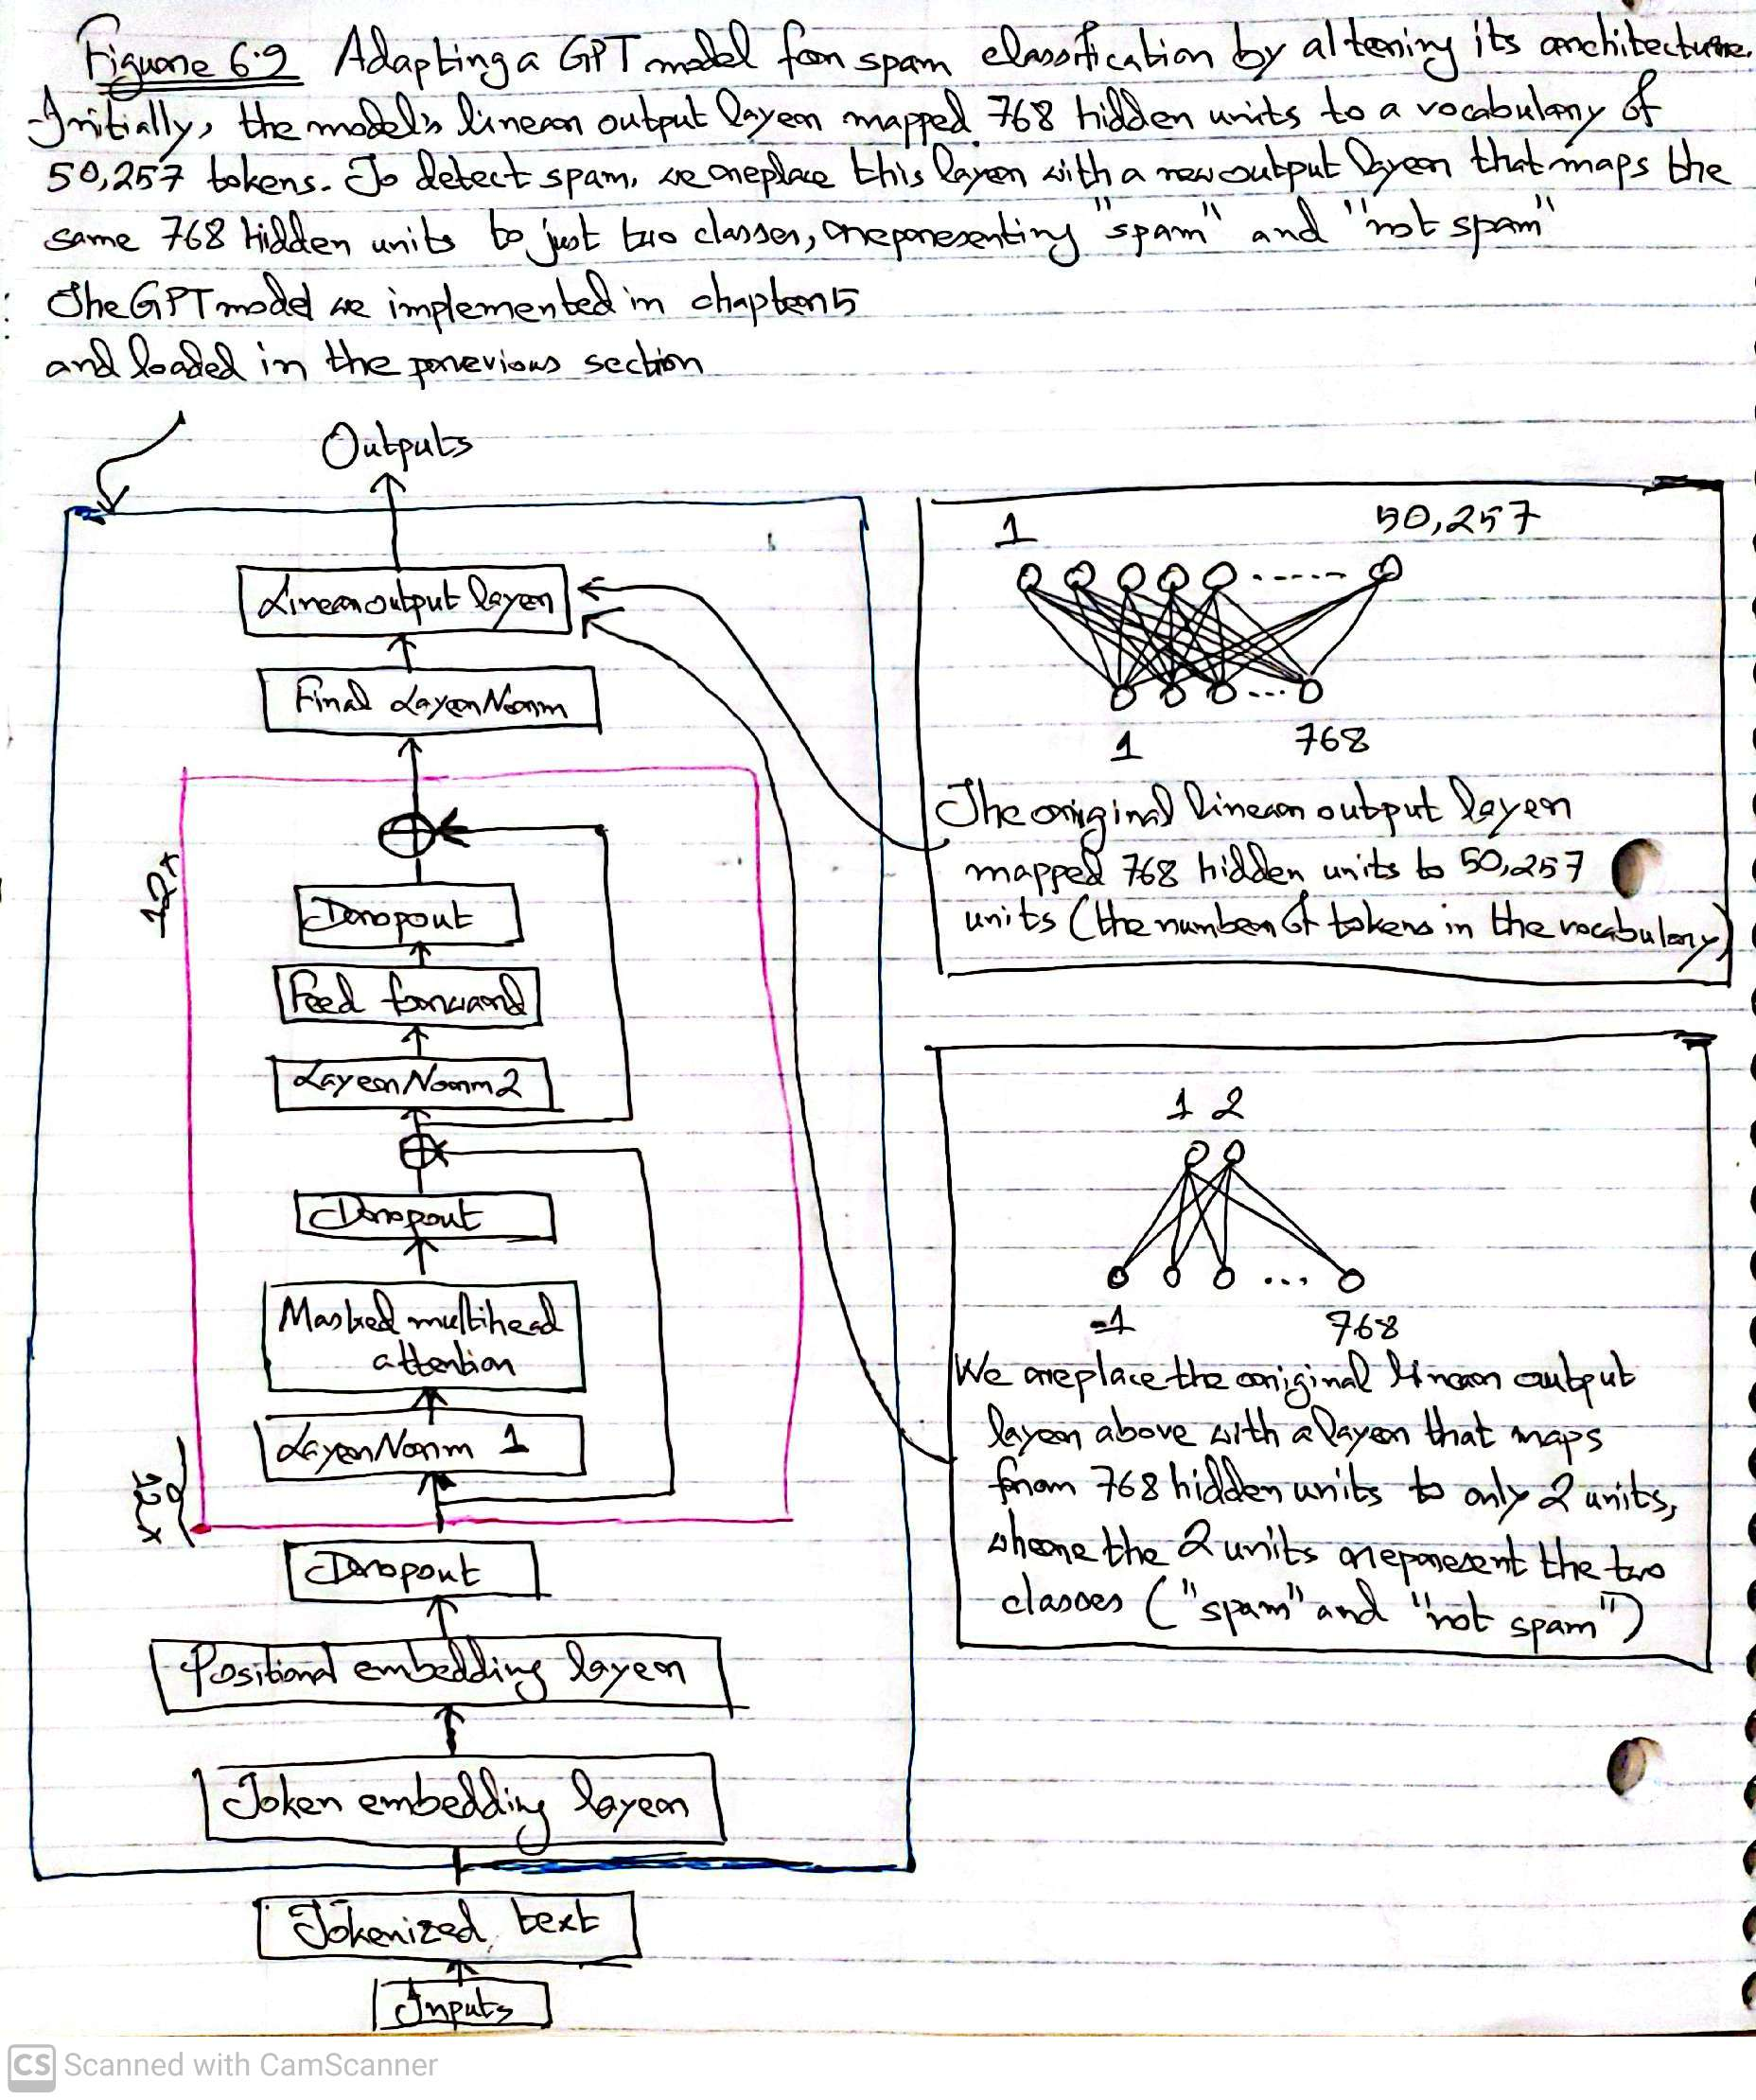

In [44]:
display(Image(filename='6_9_2.jpg', width=800))

In [42]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

### **Make all the layers nontrainable or freeze the model.**

In [43]:
for param in model.parameters():
  param.requires_grad = False

### **Now, replace the output layer.**

Replace `model.out_head` that originally mapped layer inputs to 50,257 dimensions or the size of the vocabulary.

In [49]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

The new output layer `model.out_head` has `requires_grad` set to `True` by default.

But, from practice, it has been found that fine-tuning additional layers can noticeably improve the predictive performance of the model. We will also fine-tune the last transformer block and the final `LayerNorm` module.

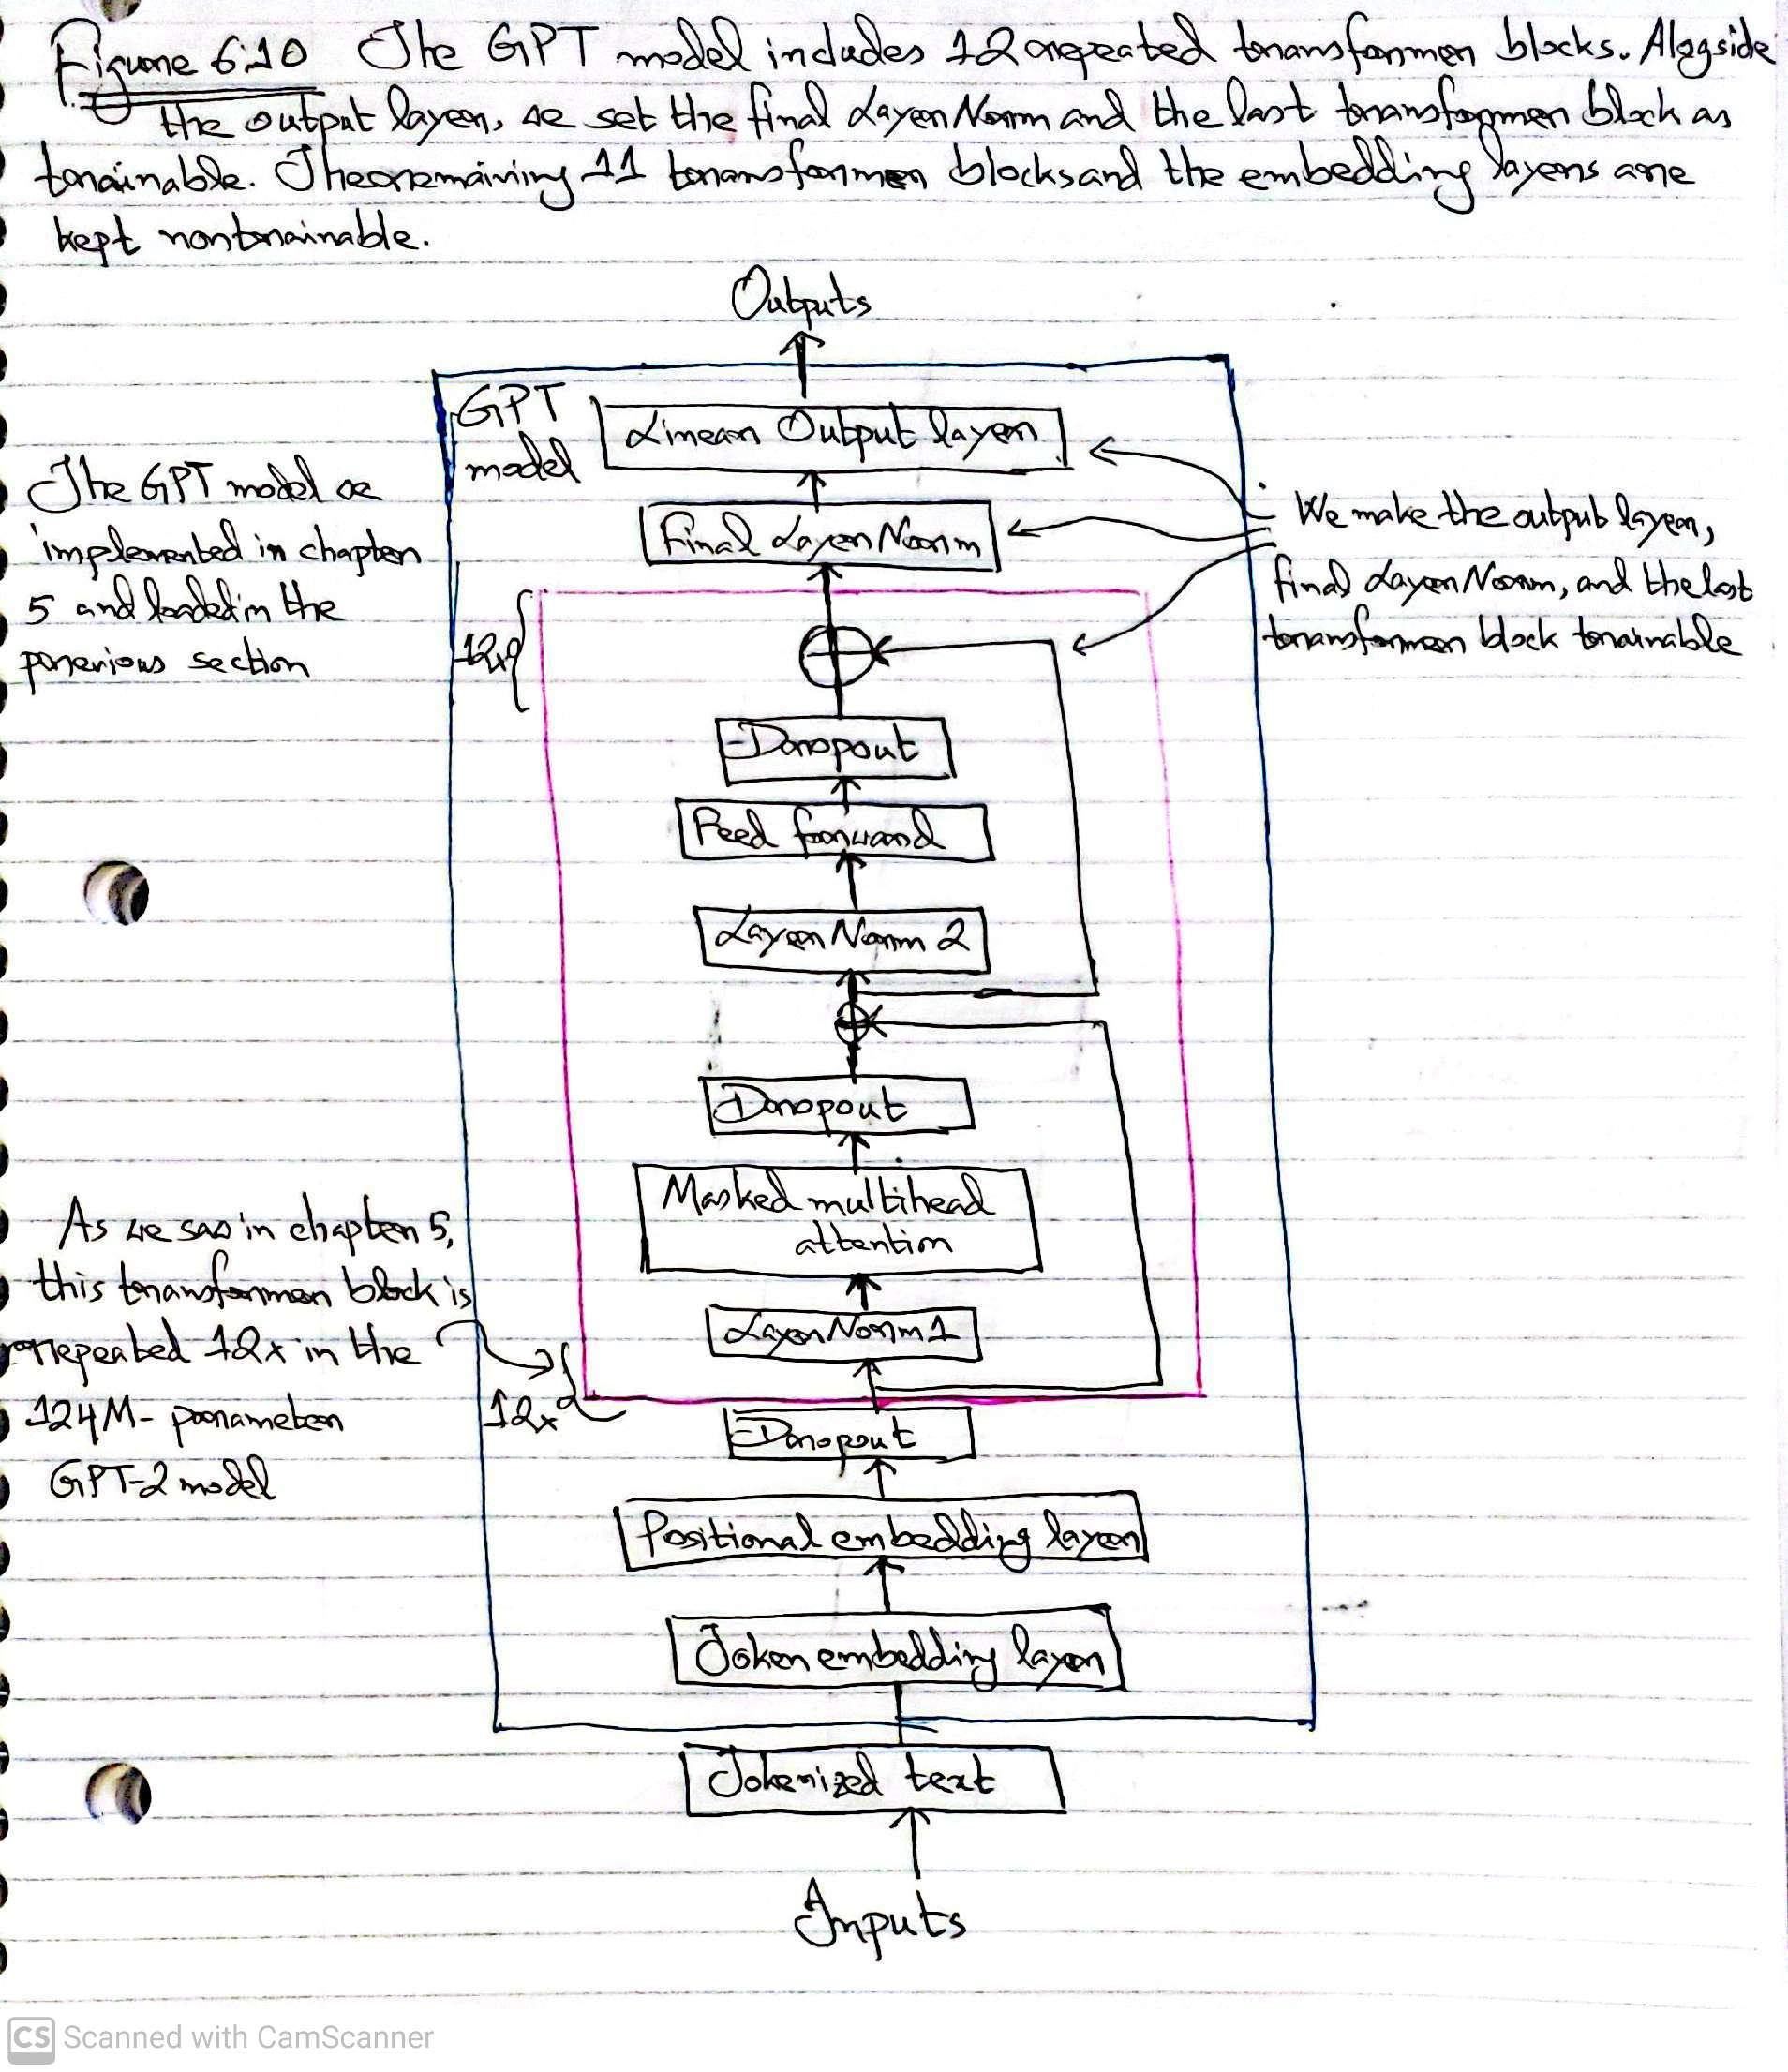

In [45]:
display(Image(filename='6_10.jpg', width=800))

In [50]:
for param in model.trf_blocks[-1].parameters():
  param.requires_grad = True
for param in model.final_norm.parameters():
  param.requires_grad = True

Even without further tuning, we can use this model now.

In [51]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0) # unsqueeze make it (1, 4) instead of size [4]
inputs.shape

torch.Size([1, 4])

In [52]:
with torch.no_grad():
  outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-0.6458, -0.7218],
         [-0.8805, -0.3163],
         [-1.1334, -0.7274],
         [-1.3001, -0.9750]]])
Outputs dimensions: torch.Size([1, 4, 2])


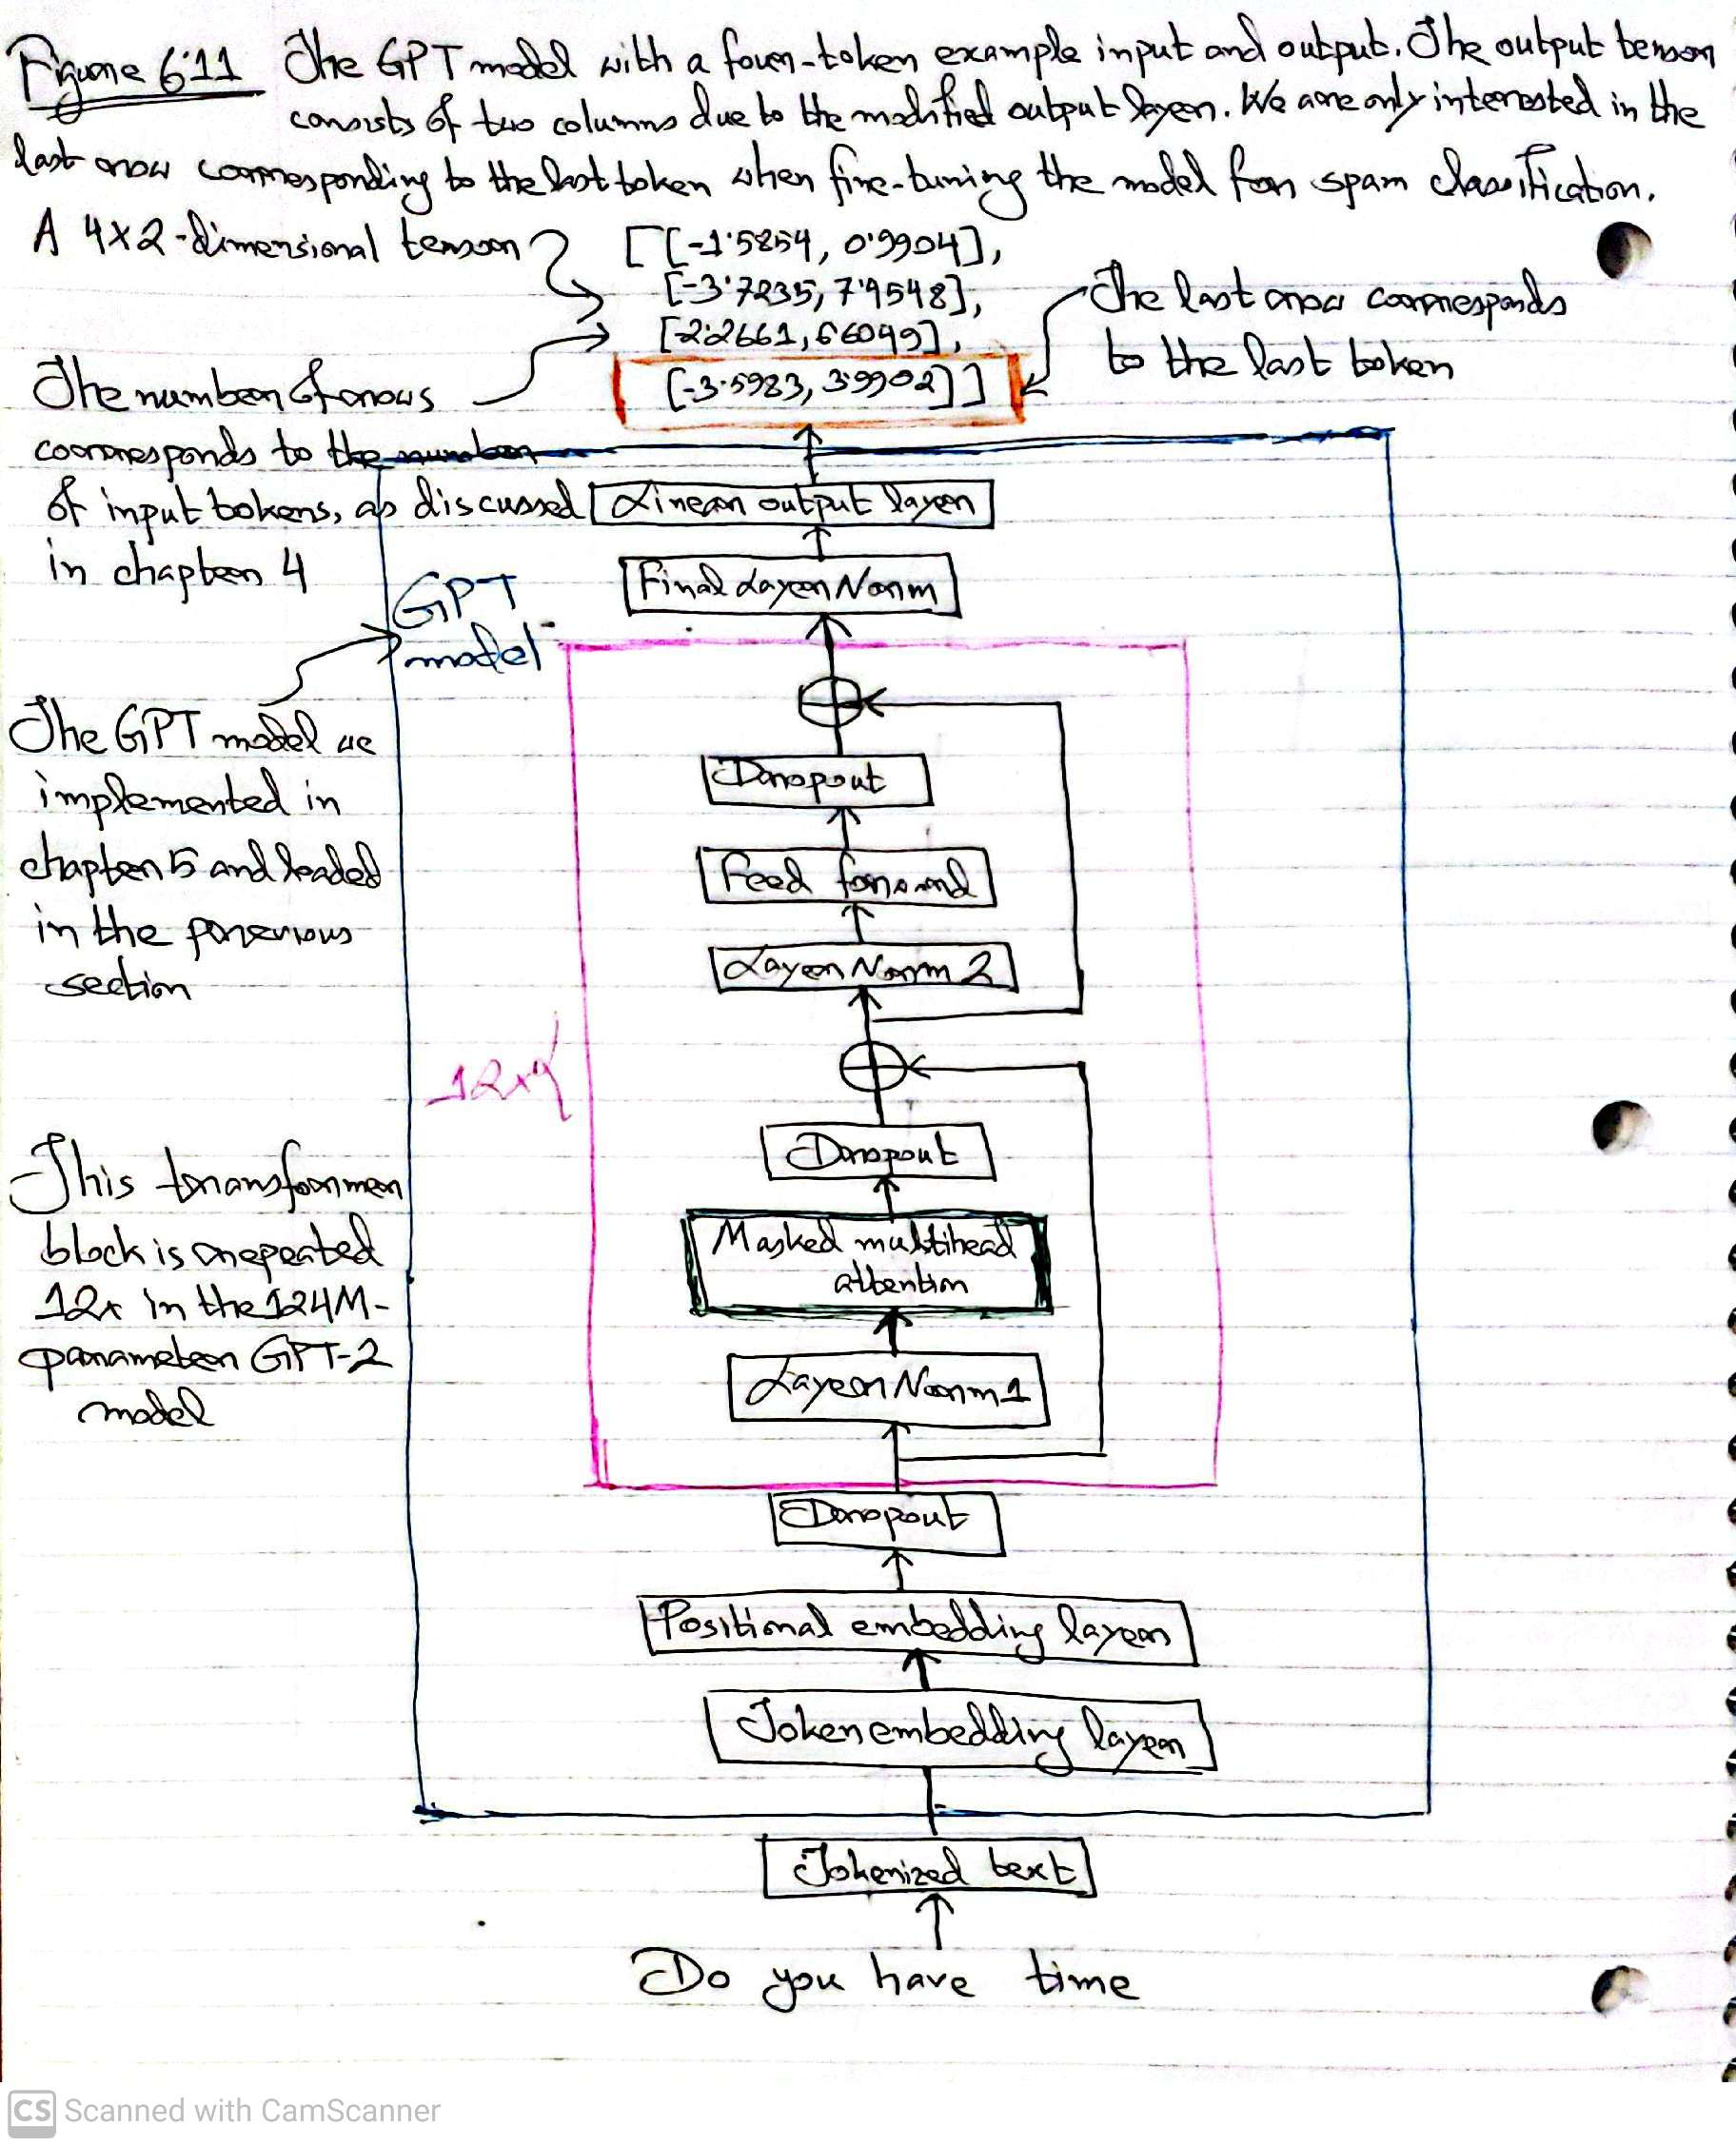

In [57]:
display(Image(filename='6_11.jpg', width=800))

Now, the output has the size `[1, 4, 2]` instead of `[1, 4, 50257]`. Now, we will focus on the last row corresponding to the last output token.

In [53]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-1.3001, -0.9750]])


In [54]:
print("Last output token shape:", outputs[:, -1, :].shape)

Last output token shape: torch.Size([1, 2])


We will need to convert this into class-label prediction. But why are we interested in the last output token only?

In causal attention mask, mask restricts a token's focus to its current position and to the positions behind this. Thus each token is influenced by itself and the ones preceding it when we use `causal attention mask`.

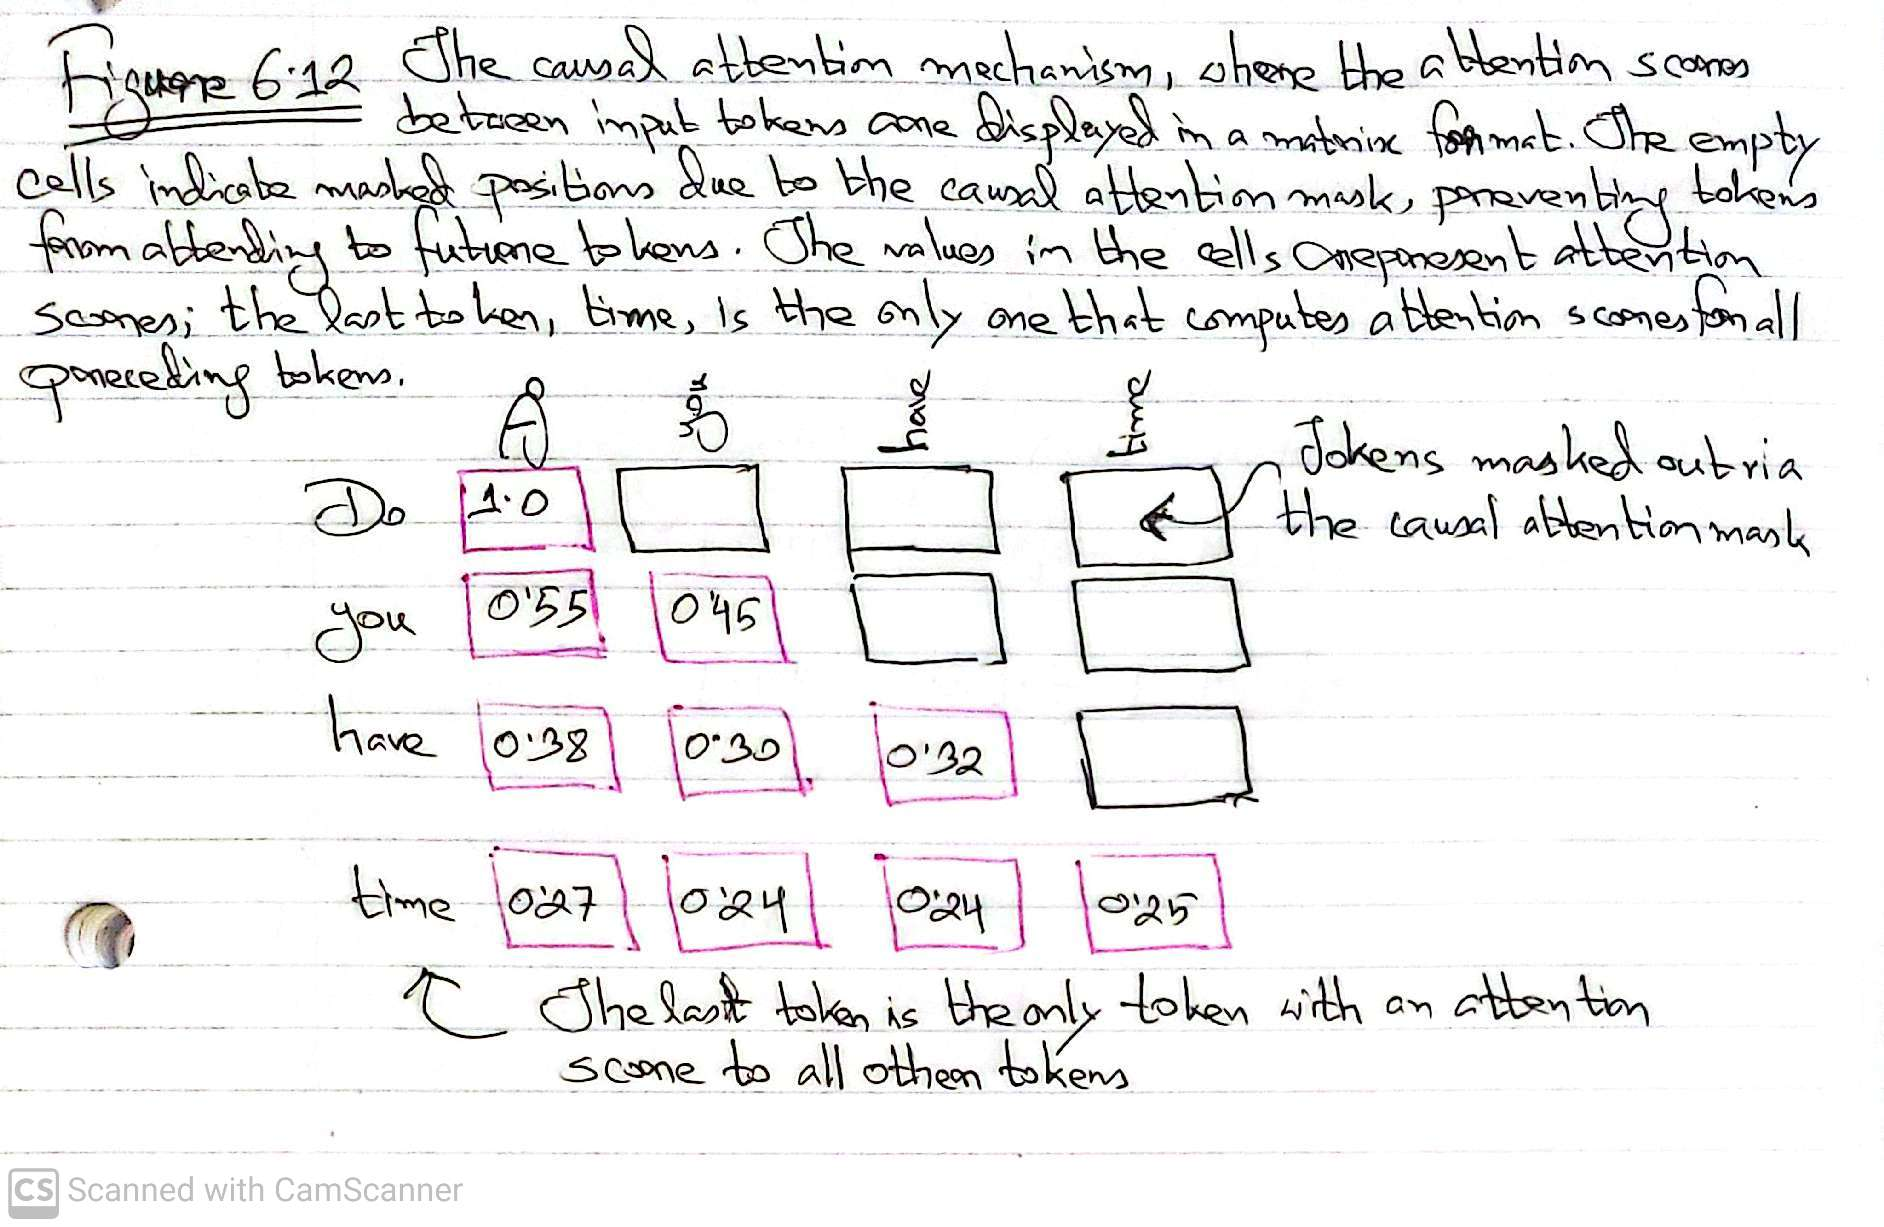

In [58]:
display(Image(filename='6_12.jpg', width=800))

In causal attention mask, as we can also see in the figure above, only the last token has access to data from all the previous tokens. Thus, for this spam classification task, we focus on this last token in this fine-tuning process.

### Calculating the classification accuracy

We convert the the 50,257 outputs into probabilities via `softmax` function for each next token prediction and return the position of the highest probability among all the 50,257 probabilities using `argmax` function. For our spam vs not spam classification, **instead of 50,257 dimensional output, we consider 2-dimensional outputs**.

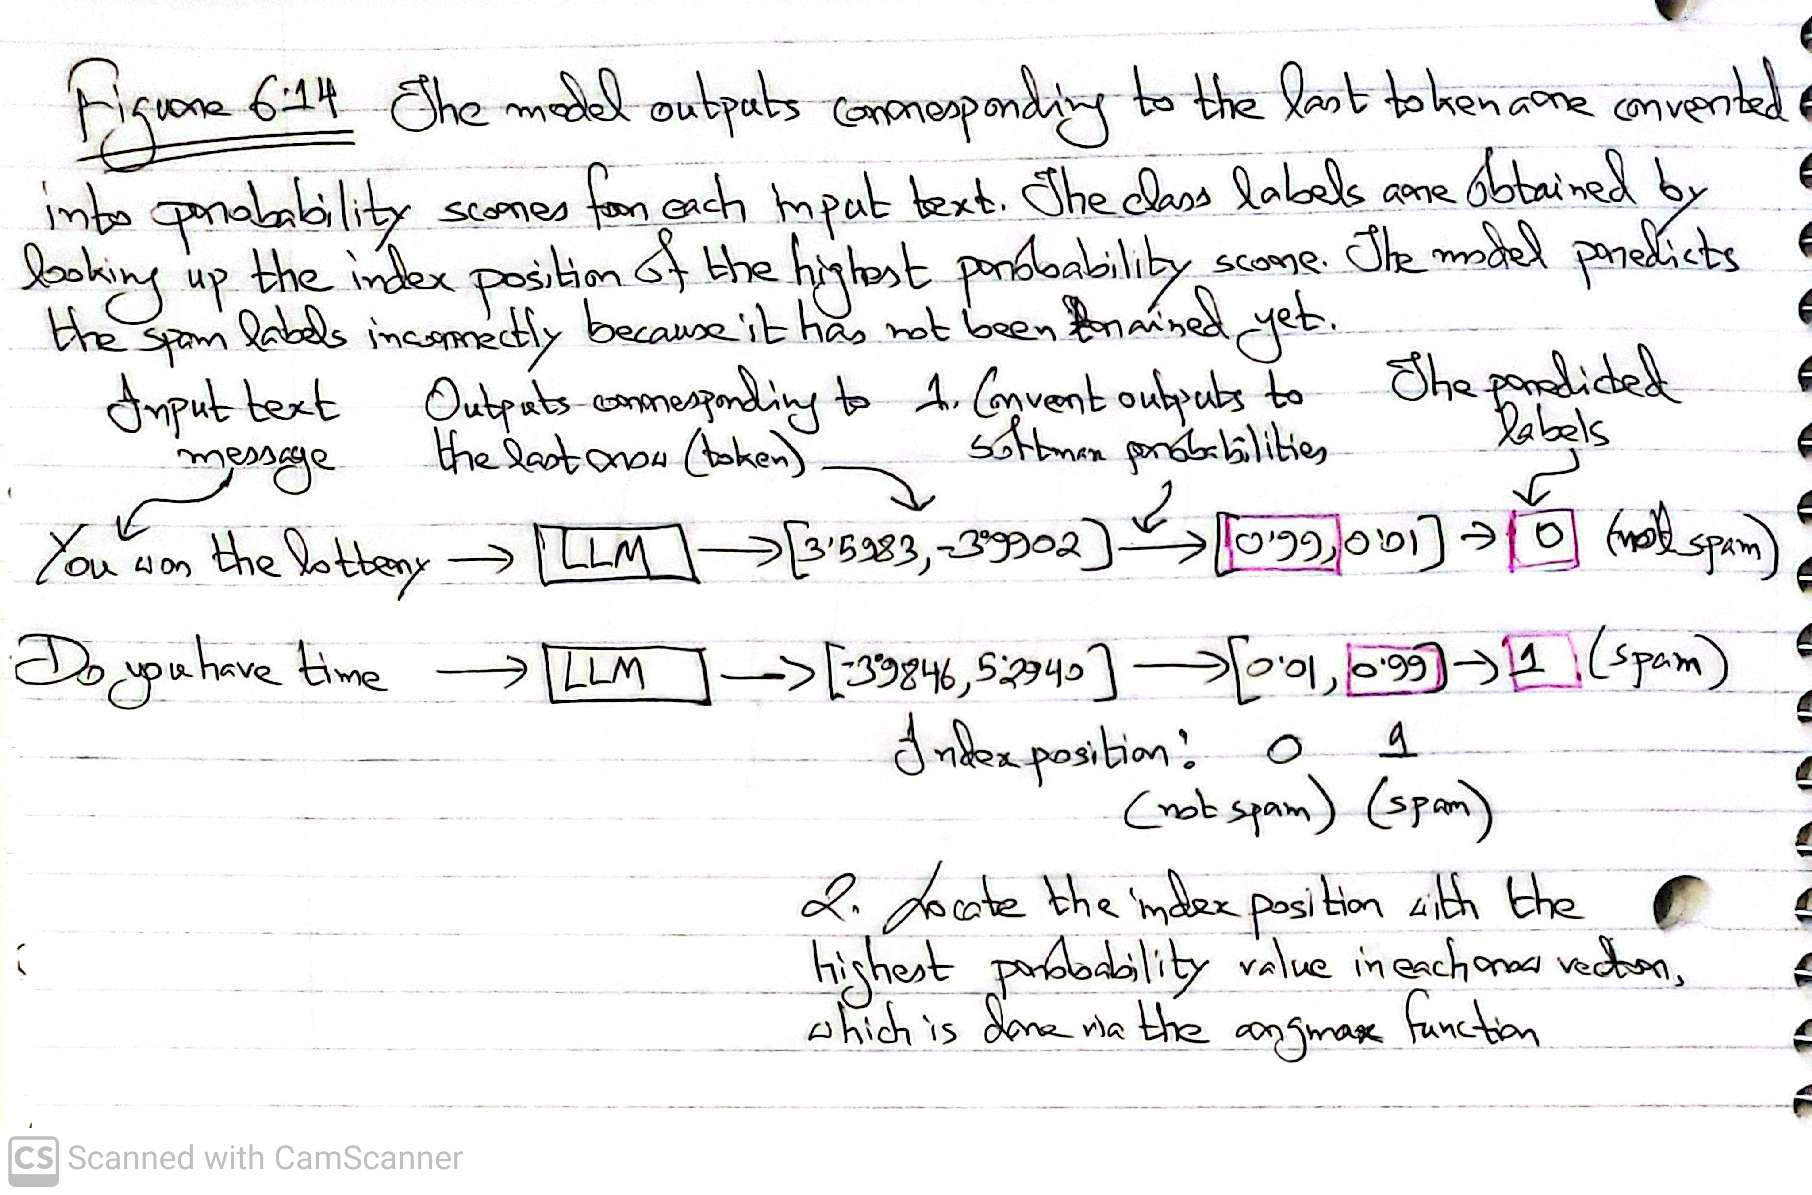

In [59]:
display(Image(filename='6_14.jpg', width=800))

The last token output is:

In [60]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-1.3001, -0.9750]])


The class labels are:

In [61]:
probas = torch.softmax(outputs[:,-1,:], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


We can also use the following.

In [62]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


Now, we write the function below to apply the `argmax` based prediction.

In [64]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)


            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )

        else:
            break
    return correct_predictions / num_examples

In [ ]:
import torch  # Importing PyTorch, a deep learning framework

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    """
    Calculates the accuracy of a PyTorch model using a data loader.

    Parameters:
    data_loader (torch.utils.data.DataLoader): The data loader containing input features and target labels.
    model (torch.nn.Module): The PyTorch model to evaluate.
    device (torch.device): The device (CPU or GPU) where computations will be performed.
    num_batches (int, optional): The number of batches to evaluate. If None, evaluates all batches.

    Returns:
    float: The accuracy of the model on the evaluated batches.
    """

    model.eval()  # Sets the model to evaluation mode (disables dropout and batch normalization)

    correct_predictions, num_examples = 0, 0  # Initialize counters for correct predictions and total examples

    if num_batches is None:
        num_batches = len(data_loader)  # If num_batches is not specified, use all available batches
    else:
        num_batches = min(num_batches, len(data_loader))
        # Ensures we do not evaluate more batches than available in the data_loader

    # Iterate over the data_loader, fetching input data and target labels
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:  # Process only up to the specified number of batches
            input_batch = input_batch.to(device)  # Move input batch to the specified device (CPU/GPU)
            target_batch = target_batch.to(device)  # Move target labels to the same device

            with torch.no_grad():
                # Disables gradient calculation since we are only doing inference (saves memory and computation)
                logits = model(input_batch)[:, -1, :]
                # Forward pass: Pass input through the model to get raw output (logits).
                # Assumption: The model outputs a 3D tensor where the second dimension is the sequence length.
                # `[:, -1, :]` selects the last time step's output (relevant for sequence models like RNNs/LSTMs).

            predicted_labels = torch.argmax(logits, dim=-1)
            # Get the predicted class labels by selecting the index with the highest value in logits
            # torch.argmax(logits, dim=-1) computes the index of the max value along the last dimension

            num_examples += predicted_labels.shape[0]
            # Update the total number of examples processed

            correct_predictions += (predicted_labels == target_batch).sum().item()
            # Count how many predictions match the actual labels and add to the correct predictions count
            # (predicted_labels == target_batch) creates a boolean tensor where True = 1 and False = 0
            # `.sum()` counts the number of True values, and `.item()` converts it to a Python integer

        else:
            break  # Stop processing if the specified number of batches has been reached

    return correct_predictions / num_examples  # Compute and return accuracy as correct predictions / total examples


Now, calculate classification accuracies across various datasets estimated from 10 batches only.

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 46.25%
Test accuracy: 50.00%


We can see that the prediction accuracies are almost 50% or a random prediction. So, to improve this, we need to fine-tune the model.

Before we fine-tune the model, we need to define the loss function that will be optimized during training. We will use cross-entropy loss as classification accuracy is not a differentiable function.

Here, we will **focus on only the last token `model(input_batch)[:, -1, :]` and not all the tokens `model(input_batch)`**.

## Define the loss function

Function to colmpute loss for a single batch.

In [66]:
import torch  # Importing PyTorch, a deep learning framework

def calc_loss_batch(input_batch, target_batch, model, device):
    """
    Computes the loss for a single batch of data using a given model.

    Parameters:
    input_batch (torch.Tensor): A batch of input features.
    target_batch (torch.Tensor): The corresponding target labels for the input batch.
    model (torch.nn.Module): The PyTorch model to evaluate.
    device (torch.device): The device (CPU or GPU) where computations will be performed.

    Returns:
    torch.Tensor: The computed loss for the batch.
    """

    input_batch = input_batch.to(device)
    # Moves the input batch (features) to the specified device (CPU or GPU).
    # This is necessary for efficient computation on a GPU if available.

    target_batch = target_batch.to(device)
    # Moves the target labels (true class labels) to the same device as the model.

    logits = model(input_batch)[:, -1, :]
    # Performs a forward pass through the model to obtain predictions (logits).
    # The model outputs a 3D tensor (batch_size, sequence_length, num_classes).
    # `[:, -1, :]` selects the output from the last time step (useful for sequence models like RNNs/LSTMs).
    # This assumes the model returns a tensor where predictions are along the last dimension.

    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    # Computes the cross-entropy loss, a standard loss function for classification problems.
    # Cross-entropy measures the difference between predicted probabilities (logits) and true labels.
    # `torch.nn.functional.cross_entropy` expects raw logits and applies the softmax function internally.
    # The function takes:
    #   - `logits`: Model outputs (before softmax).
    #   - `target_batch`: Ground truth class labels.
    # It returns a scalar loss value representing how far the predictions are from the true labels.

    return loss  # Returns the computed loss for this batch.

Now, here is a function to calculate **loss for all the batches** in a data loader.

In [67]:
import torch  # Importing PyTorch, a deep learning framework

def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    Computes the average loss over multiple batches in a data loader.

    Parameters:
    data_loader (torch.utils.data.DataLoader): The data loader containing input features and target labels.
    model (torch.nn.Module): The PyTorch model to evaluate.
    device (torch.device): The device (CPU or GPU) where computations will be performed.
    num_batches (int, optional): The number of batches to evaluate. If None, evaluates all batches.

    Returns:
    float: The average loss over the evaluated batches.
    """

    total_loss = 0  # Initialize a variable to accumulate total loss over all processed batches.

    if len(data_loader) == 0:
        # Check if the data loader is empty (has no data).
        # If it is empty, return NaN (Not a Number) to indicate that loss cannot be computed.
        return float("nan")

    elif num_batches is None:
        # If num_batches is not specified, process all available batches.
        num_batches = len(data_loader)

    else:
        num_batches = min(num_batches, len(data_loader))
        # If num_batches is specified, ensure it does not exceed the total number of batches.

    # Iterate over the data_loader, fetching input data and target labels.
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:  # Process only up to the specified number of batches.

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # Call the `calc_loss_batch` function to compute the loss for this batch.

            total_loss += loss.item()
            # Add the computed loss for this batch to the total loss.
            # `.item()` converts a PyTorch tensor to a standard Python float, making it easier to accumulate.

        else:
            break  # Stop processing if the specified number of batches has been reached.

    return total_loss / num_batches
    # Compute the average loss by dividing the total accumulated loss by the number of batches processed.
    # This gives a more stable loss estimate over the dataset.

### Calculating Loss Across Training, Validation, and Test Sets in PyTorch

The code snippet below calculates the average loss for training, validation, and test datasets using a function called `calc_loss_loader()`. We run this evaluation **without computing gradients**, ensuring efficient performance.

In [68]:
import torch  # Importing PyTorch, a deep learning framework

# Disable gradient calculation to optimize memory usage and speed up inference
# Since we are only evaluating the model (not training), we don't need to track gradients.
with torch.no_grad():
    # Compute the average training loss over the first 5 batches
    # Calls the calc_loss_loader function to calculate loss on a subset of the training data
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)

    # Compute the average validation loss over the first 5 batches
    # This helps assess if the model is overfitting or generalizing well
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

    # Compute the average test loss over the first 5 batches
    # This measures how well the model performs on unseen test data
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

# Print the computed training loss, validation loss, and test loss
# Uses formatted string literals (f-strings) to display values rounded to three decimal places
print(f"Training loss: {train_loss:.3f}")  # Prints training loss with 3 decimal precision
print(f"Validation loss: {val_loss:.3f}")  # Prints validation loss with 3 decimal precision
print(f"Test loss: {test_loss:.3f}")  # Prints test loss with 3 decimal precision


Training loss: 0.666
Validation loss: 0.713
Test loss: 0.705


## Fine-tuning the model on supervised data

Now, we write a simple yet effective training function called `train_classifier_simple()`. This function trains a PyTorch classification model using a given dataset while tracking loss and accuracy.

The train_classifier_simple() function:

- Trains a classification model on a dataset using mini-batch gradient descent.
- Evaluates the model periodically during training to track progress.
- Records loss and accuracy for both training and validation sets.
- Prints useful logs to monitor training and validation performance.

In [70]:
import torch  # Importing PyTorch, a deep learning framework

def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    """
    Trains a classification model using a given training dataset and evaluates it on a validation dataset.

    Parameters:
    model (torch.nn.Module): The neural network model to train.
    train_loader (torch.utils.data.DataLoader): Data loader for the training dataset.
    val_loader (torch.utils.data.DataLoader): Data loader for the validation dataset.
    optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters.
    device (torch.device): Specifies whether to train on CPU or GPU.
    num_epochs (int): Number of training epochs.
    eval_freq (int): How often (in steps) to evaluate the model during training.
    eval_iter (int): Number of batches to use when evaluating accuracy.

    Returns:
    tuple: (train_losses, val_losses, train_accs, val_accs, examples_seen) containing training and validation losses,
           training and validation accuracies, and the number of examples processed.
    """

    # Initialize lists to store training and validation losses and accuracies
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # Counter to track how many training examples have been seen
    examples_seen = 0

    # Global step counter to track the number of optimization steps taken
    global_step = -1

    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode (enables dropout, batch normalization, etc.)

        # Iterate over each batch in the training dataset
        for input_batch, target_batch in train_loader:

            optimizer.zero_grad()
            # Clears previously computed gradients. This is necessary because PyTorch accumulates gradients
            # rather than replacing them by default.

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # Computes the loss for the current batch using a predefined function `calc_loss_batch`.

            loss.backward()
            # Computes gradients of the loss with respect to the model parameters using backpropagation.

            optimizer.step()
            # Updates the model parameters using the computed gradients and the optimizer's learning rule. Uses the gradients computed by loss.backward()

            examples_seen += input_batch.shape[0]
            # Updates the total count of training examples processed.

            global_step += 1
            # Increments the global optimization step counter.

            if global_step % eval_freq == 0:
                # If the current global step is a multiple of eval_freq, evaluate the model.

                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_freq)
                # Calls a predefined function `evaluate_model` to compute training and validation loss.

                train_losses.append(train_loss)  # Store the computed training loss.
                val_losses.append(val_loss)  # Store the computed validation loss.

                print(f"Epoch {epoch + 1} (Step {global_step:06d})"
                      f" Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")
                # Print the progress, showing the current epoch, step, and loss values.
                # `{global_step:06d}` ensures the step number is zero-padded to 6 digits for readability.

        # Compute training accuracy using a subset of the training data
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)

        # Compute validation accuracy using a subset of the validation data
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

        # Print the accuracy results. The `end=""` keeps the output on the same line for better readability.
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}% | ", end="")

        # Store accuracy values for later analysis
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    # Return recorded training and validation losses, accuracies, and the number of examples processed
    return train_losses, val_losses, train_accs, val_accs, examples_seen

Now, we write `evaluate_model()` function that calculates the training and validation loss in a structured and efficient way using PyTorch. This function is identical to the one we used previously for pretraining.

The `evaluate_model()` function:

- Temporarily switches the model to evaluation mode to ensure correct behavior during inference.
- Computes the average loss for both the training and validation datasets.
- Uses `torch.no_grad()` to disable gradient computation, making evaluation faster and memory-efficient.
- Restores the model to training mode after evaluation so that training can continue.

In [71]:
import torch  # Import PyTorch, a deep learning framework

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    Evaluates a trained model by computing the average loss on both training and validation datasets.

    Parameters:
    model (torch.nn.Module): The trained PyTorch model to be evaluated.
    train_loader (torch.utils.data.DataLoader): Data loader for the training dataset.
    val_loader (torch.utils.data.DataLoader): Data loader for the validation dataset.
    device (torch.device): The device (CPU or GPU) where computations should be performed.
    eval_iter (int): The number of batches to use when evaluating loss.

    Returns:
    tuple: (train_loss, val_loss) - The average loss on the training and validation datasets.
    """

    model.eval()
    # Puts the model in evaluation mode.
    # This ensures that certain layers, like dropout and batch normalization, behave correctly during inference.

    with torch.no_grad():
        # Disables gradient computation to save memory and speed up execution.
        # During evaluation, we do not need gradients because we are not updating model weights.

        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        # Calls `calc_loss_loader()` to compute the average loss over `eval_iter` batches of the training dataset.
        # This helps track how well the model has learned the training data.

        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
        # Calls `calc_loss_loader()` to compute the average loss over `eval_iter` batches of the validation dataset.
        # This measures how well the model generalizes to unseen data.

    model.train()
    # Restores the model back to training mode.
    # This is necessary because some layers, like dropout and batch normalization, behave differently in training mode.
    # This ensures that if training continues, the model functions correctly.

    return train_loss, val_loss
    # Returns the computed training and validation losses as a tuple.
    # These values help in monitoring model performance and detecting overfitting.

## **Time to train**

Now, we train a deep learning model by initializing an optimizer, setting up hyperparameters, and tracking progress. The function below uses AdamW optimization, a manual random seed for reproducibility, and timing functionality to measure execution time.

This code does the following:

- ✅ Records the training duration to evaluate computational efficiency.
- ✅ Ensures reproducibility by setting a random seed.
- ✅ Initializes the optimizer to update model parameters efficiently.
- ✅ Runs the training loop while tracking losses and accuracy.
- ✅ Prints the total training time in minutes.


In [72]:
import time  # Importing the time module to track execution time

# Record the current time before training starts
start_time = time.time()
# `time.time()` returns the number of seconds since the epoch (January 1, 1970).
# This will be used later to calculate the total training duration.

torch.manual_seed(123)
# Sets the random seed for PyTorch to ensure reproducibility.
# Ensures that random processes (e.g., weight initialization, shuffling of data) produce the same results each time.
# This is useful for debugging and comparing different training runs.

# Initialize the AdamW optimizer to update the model parameters during training
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
# `torch.optim.AdamW`: A variant of the Adam optimizer that correctly applies weight decay.
# Arguments:
# - `model.parameters()`: Retrieves all trainable parameters of the model.
# - `lr=5e-5`: The learning rate (step size) that controls how much the weights change during training.
# - `weight_decay=0.1`: A regularization term that prevents large weights, reducing the risk of overfitting.

num_epochs = 5
# Defines the total number of epochs (iterations over the full dataset).
# More epochs allow the model to learn better, but too many may lead to overfitting.

# Call the training function to train the model and track performance metrics
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model,  # The deep learning model that we are training
        train_loader,  # DataLoader for the training dataset, providing mini-batches of data
        val_loader,  # DataLoader for the validation dataset, used to assess model performance
        optimizer,  # The optimizer that updates the model parameters (AdamW in this case)
        device,  # Specifies whether the training is performed on a CPU or GPU
        num_epochs=num_epochs,  # Number of complete training cycles through the dataset
        eval_freq=50,  # The model's performance will be evaluated every 50 steps
        eval_iter=5  # Only 5 batches will be used for evaluation to reduce computation time
    )
# The function `train_classifier_simple()`:
# - Trains the model using mini-batch gradient descent.
# - Periodically evaluates the model on both training and validation datasets.
# - Tracks loss and accuracy over time.
# - Returns:
#   - `train_losses`: A list containing the recorded training loss at each evaluation step.
#   - `val_losses`: A list containing the recorded validation loss at each evaluation step.
#   - `train_accs`: A list of recorded training accuracies.
#   - `val_accs`: A list of recorded validation accuracies.
#   - `examples_seen`: The total number of training examples processed.

# Record the time after training has completed
end_time = time.time()
# `time.time()` is called again to measure when the training has finished.

# Calculate the total execution time in minutes
execution_time_minutes = (end_time - start_time) / 60
# Computes the difference between `end_time` and `start_time`, giving the total training duration in seconds.
# Dividing by 60 converts the duration into minutes.

# Print the total training time, formatted to 2 decimal places
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
# The `f"..."` syntax is a formatted string literal (f-string) that allows inserting variables into a string.
# `{execution_time_minutes:.2f}` ensures the time is displayed with two decimal places.


Epoch 1 (Step 000000) Train loss 0.718, Val loss 0.727
Epoch 1 (Step 000050) Train loss 0.658, Val loss 0.656
Epoch 1 (Step 000100) Train loss 0.577, Val loss 0.577
Training accuracy: 82.50% | Validation accuracy: 75.00% | Epoch 2 (Step 000150) Train loss 0.383, Val loss 0.334
Epoch 2 (Step 000200) Train loss 0.309, Val loss 0.292
Epoch 2 (Step 000250) Train loss 0.367, Val loss 0.340
Training accuracy: 77.50% | Validation accuracy: 92.50% | Epoch 3 (Step 000300) Train loss 0.344, Val loss 0.308
Epoch 3 (Step 000350) Train loss 0.344, Val loss 0.311
Training accuracy: 82.50% | Validation accuracy: 92.50% | Epoch 4 (Step 000400) Train loss 0.355, Val loss 0.291
Epoch 4 (Step 000450) Train loss 0.325, Val loss 0.303
Epoch 4 (Step 000500) Train loss 0.363, Val loss 0.292
Training accuracy: 92.50% | Validation accuracy: 90.00% | Epoch 5 (Step 000550) Train loss 0.355, Val loss 0.301
Epoch 5 (Step 000600) Train loss 0.356, Val loss 0.343
Training accuracy: 87.50% | Validation accuracy: 92.5

### Plotting the classification loss

Once a deep learning model has been trained, it's crucial to **visualize its performance** over time. This helps in understanding whether the model is learning effectively, overfitting, or underfitting.

The code below **plots training and validation loss curves** to provide insights into the model’s learning behavior.

What This Code Does

- ✅ Defines a function plot_values() to generate a line plot comparing training and validation performance.
- ✅ Uses Matplotlib (plt.plot()) to create a visualization of how the model’s loss changes over time.
- ✅ Adds dual X-axes to display both epochs and examples seen for better interpretability.
- ✅ Saves the plot as a PDF (plt.savefig()) for documentation and analysis.

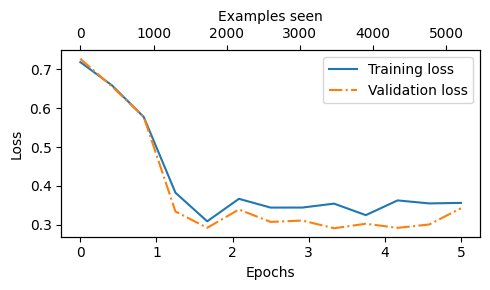

In [73]:
import matplotlib.pyplot as plt  # Import Matplotlib, a library for creating visualizations

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    """
    Plots the training and validation values (e.g., loss or accuracy) over the epochs.

    Parameters:
    - epochs_seen (tensor or list): X-axis values representing the epochs completed.
    - examples_seen (tensor or list): Alternative X-axis values representing total examples processed.
    - train_values (list): The metric values (e.g., loss or accuracy) recorded during training.
    - val_values (list): The metric values recorded for the validation dataset.
    - label (str, default="loss"): Specifies what is being plotted (e.g., "loss" or "accuracy").

    This function generates a dual-axis plot:
    - The primary X-axis represents **epochs**.
    - The secondary X-axis represents **examples seen**.
    - The Y-axis represents the metric being tracked (e.g., loss, accuracy).
    """

    # Create a figure (fig) and a primary axis (ax1) for plotting
    fig, ax1 = plt.subplots(figsize=(5, 3))
    # `plt.subplots()` creates a figure and an axis for plotting.
    # `figsize=(5,3)` sets the size of the figure to 5 inches wide and 3 inches tall.

    # Plot the training values over epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    # `ax1.plot(X, Y)` plots the training data where:
    # - `epochs_seen` is on the X-axis (epochs).
    # - `train_values` is on the Y-axis (metric values, e.g., loss).
    # - `label=f"Training {label}"` dynamically sets the legend label (e.g., "Training Loss" or "Training Accuracy").

    # Plot the validation values over epochs with a different line style
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",  # Dashed-dot line for validation values
        label=f"Validation {label}"
    )
    # Similar to the previous plot but for validation values.
    # `linestyle="-."` makes the validation line visually distinct.

    # Set labels for the primary X-axis and Y-axis
    ax1.set_xlabel("Epochs")  # Labels the X-axis as "Epochs" (training cycles).
    ax1.set_ylabel(label.capitalize())  # Labels the Y-axis using the provided metric name (capitalized).

    # Add a legend to distinguish between training and validation lines
    ax1.legend()
    # `ax1.legend()` displays the labels assigned to each line in the plot.

    # Create a secondary X-axis that represents the number of examples processed
    ax2 = ax1.twiny()
    # `ax1.twiny()` creates a second X-axis (aligned with the first one but at the top).

    # Plot the same training values but make the line invisible (`alpha=0`) to only show the secondary X-axis
    ax2.plot(examples_seen, train_values, alpha=0)
    # `alpha=0` makes the second line invisible while still aligning the X-axis with "examples seen".

    # Set the label for the secondary X-axis
    ax2.set_xlabel("Examples seen")
    # Labels the secondary X-axis as "Examples seen" to track progress in terms of data processed.

    # Adjust layout to prevent overlapping elements
    fig.tight_layout()
    # Ensures that all labels and elements fit within the figure without overlap.

    # Save the plot as a PDF file with the given label (e.g., "loss-plot.pdf" or "accuracy-plot.pdf")
    plt.savefig(f"{label}-plot.pdf")
    # `plt.savefig("filename.pdf")` saves the plot as a PDF file for later reference.

    # Display the plot
    plt.show()
    # `plt.show()` renders the figure in the output window.

# Generate tensors for the X-axis (epochs and examples seen) based on the recorded loss values
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# `torch.linspace(start, end, steps)` generates evenly spaced values between `0` and `num_epochs`.
# The number of steps (`len(train_losses)`) matches the number of recorded loss values.
# The function torch.linspace(start, end, steps) generates a 1D tensor of evenly spaced values between start and end, with steps number of elements.

examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
# Generates evenly spaced values between `0` and `examples_seen`.
# This aligns the number of training examples seen with the recorded loss values.

# Call the function to generate the training vs. validation loss plot
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)
# Passes:
# - `epochs_tensor`: X-axis values representing epochs.
# - `examples_seen_tensor`: Alternative X-axis values for total training examples processed.
# - `train_losses`: Training loss values.
# - `val_losses`: Validation loss values.

As there is a sharp downward move for the loss, we can say that the model is learning well from the training data.

### **Plot classification accuracies**

Now, plot training and validation accuracy over time.

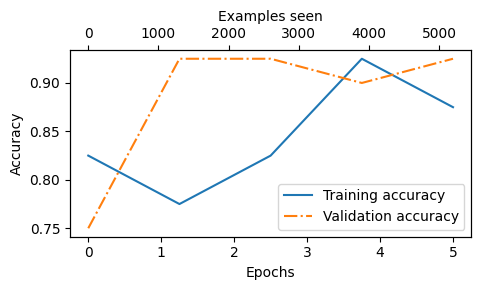

In [74]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

Now, calculate training, validation and test accuracy across the entire dataset.

In [75]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 87.02%
Validation accuracy: 89.26%
Test accuracy: 85.00%


## Save the model

After training a deep learning model, it's essential to save its state so that it can be reused later without retraining from scratch. Now, we will save the trained model, optimizer state, and training history using PyTorch's `torch.save()` function.

By saving both the model parameters and training history, we can later resume training, fine-tune the model, or analyze training progress without starting over.

What This Code Does
- ✅ Defines a file path where the model and training data will be stored.
- ✅ Saves the model’s parameters (state_dict) so that it can be reloaded later.
- ✅ Saves the optimizer’s state to resume training with the same optimization settings.
- ✅ Stores training history (losses, accuracies, examples seen) for analysis.
- ✅ Prints a confirmation message once the saving process is complete.



In [76]:
# Define save path for the trained model and training history
model_path = "classification_trained_model.pth"
# This is the file name where the model, optimizer, and training history will be saved.
# The `.pth` extension is commonly used for saving PyTorch models.

# Save model state, optimizer state, and training history
torch.save({
    'model_state_dict': model.state_dict(),
    # Saves only the **trainable parameters (weights and biases)** of the model.
    # `model.state_dict()` returns a dictionary containing all model parameters.
    # This makes the file **lighter** compared to saving the full model.

    'optimizer_state_dict': optimizer.state_dict(),
    # Saves the **state of the optimizer**.
    # This includes information like learning rate, momentum (if applicable), and other hyperparameters.
    # Saving this allows resuming training without losing optimizer settings.

    'num_epochs': num_epochs,
    # Saves the total number of epochs the model has been trained for.
    # This is useful for tracking progress and continuing training if needed.

    'train_losses': train_losses,
    # Stores the list of training loss values recorded during training.
    # Helps analyze how the model's loss evolved over time.

    'val_losses': val_losses,
    # Stores the list of validation loss values recorded during training.
    # Useful for checking if the model is overfitting or improving over epochs.

    'train_accs': train_accs,
    # Stores the list of training accuracy values at different evaluation points.
    # Helps visualize how well the model is learning from the training dataset.

    'val_accs': val_accs,
    # Stores the list of validation accuracy values at different evaluation points.
    # Helps measure how well the model is generalizing to unseen data.

    'examples_seen': examples_seen
    # Saves the total number of training examples processed.
    # This is useful for visualizing training progress and comparing models trained on different dataset sizes.

}, model_path)
# `torch.save()` is a PyTorch function used to save a dictionary of objects to a file.
# This stores the model parameters, optimizer state, and training history in the specified `model_path`.

# Print a confirmation message after saving the model and training history
print(f"Model and training history saved to {model_path}")
# Prints a message to confirm that the model and training details have been successfully saved.
# The formatted string (`f""`) ensures the `model_path` is dynamically included in the message.

Model and training history saved to classification_trained_model.pth


### Load the model

After training and saving a model, the next step is to reload it for further use—whether for **inference**, **resuming training**, or **analyzing past training progress**. The code below restores **a saved model**, **optimizer**, and **training history**, making it easy to **continue from where you left off**.

In [77]:
# Define the path where the trained model and training history were saved
model_path = "classification_trained_model.pth"
# The saved model file is stored in the current directory with the filename `classification_trained_model.pth`.
# The `.pth` extension is commonly used in PyTorch for saving model checkpoints.

# Load the checkpoint (saved model state and training history)
checkpoint = torch.load(model_path)
# `torch.load(model_path)` loads the saved dictionary from the file.
# This dictionary contains:
# - Model parameters (`state_dict`)
# - Optimizer parameters (`state_dict`)
# - Training metadata such as epochs, losses, accuracies, and examples seen.
# It allows us to restore the model and training progress.

# Load model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
# Restores the **trained weights and biases** into the model.
# `model.state_dict()` stores only the model's parameters (not the entire model structure).
# `load_state_dict(checkpoint['model_state_dict'])` loads the saved parameters back into the model.

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Restores the **optimizer state**, including learning rate, momentum, and past gradients.
# This allows training to resume **without losing optimizer progress**.
# Without this, the optimizer would reset, leading to slower convergence.

# Restore training history
num_epochs = checkpoint['num_epochs']
# Restores the total number of epochs the model was trained for.
# This helps if you want to continue training from where you left off.

train_losses = checkpoint['train_losses']
# Retrieves the list of training loss values recorded during training.
# Useful for plotting training loss curves and analyzing learning progress.

val_losses = checkpoint['val_losses']
# Retrieves the list of validation loss values recorded during training.
# Helps to evaluate whether the model was overfitting or improving over time.

train_accs = checkpoint['train_accs']
# Retrieves the list of training accuracy values recorded at different evaluation points.
# Helps track how well the model was learning from the training data.

val_accs = checkpoint['val_accs']
# Retrieves the list of validation accuracy values recorded at different evaluation points.
# This helps assess whether the model was generalizing well to unseen data.

examples_seen = checkpoint['examples_seen']
# Restores the total number of training examples processed.
# This is useful for tracking training progress and comparing training across different datasets.

# Print a confirmation message to indicate successful loading
print("Model and training history loaded successfully!")
# Confirms that the model, optimizer, and training data have been successfully reloaded.
# Ensures that no errors occurred during loading.

Model and training history loaded successfully!


### Using the LLM as a spam classifier

Now, we will classify spam messages using the GPT-based spam classification model that we just fine-tuned.

What the code below does:

- ✅ Prepares input text by encoding it into numerical format.
- ✅ Handles padding and truncation to match the model's supported context length.
- ✅ Feeds the input into the GPT model in evaluation mode (no gradient computation needed).
- ✅ Generates predictions by extracting logits (raw scores) and determining the most likely label.
- ✅ Returns "spam" or "not spam" based on the predicted class.

In [78]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    """
    Classifies a given text message as either 'spam' or 'not spam' using a fine-tuned GPT model.

    Parameters:
    - text (str): The input message to classify.
    - model (torch.nn.Module): The fine-tuned GPT-based spam classification model.
    - tokenizer (Tokenizer): Tokenizer to convert text into tokenized input for the model.
    - device (torch.device): Specifies whether to run the model on CPU or GPU.
    - max_length (int, optional): The maximum length of input tokens allowed for classification.
    - pad_token_id (int, default=50256): The token ID used for padding short inputs.

    Returns:
    - str: "spam" if the message is classified as spam, otherwise "not spam".
    """

    model.eval()  # Sets the model to evaluation mode (disables dropout layers and batch normalization).

    # Convert the input text into token IDs using the tokenizer
    input_ids = tokenizer.encode(text)
    # The tokenizer encodes the text into a sequence of numerical token IDs.
    # Example: "Win a free iPhone now!" → [1342, 567, 892, 401, 763, 2093]

    # Determine the model's maximum supported context length
    supported_context_length = model.pos_emb.weight.shape[0]
    # self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    # Here, `context_length=1024`, which means the model can process a maximum of 1024 tokens.
    # `shape[0]` correctly represents the **number of positions (context length)** the model can handle.

    # (Correction Note) The book mistakenly uses `shape[1]` for context length.
    # `shape[1]` represents the embedding dimension, NOT the context length.

    # Truncate the input if it exceeds the maximum allowed length
    input_ids = input_ids[:min(max_length, supported_context_length)]
    # This ensures that the input does not exceed the model’s context length.
    # If `max_length=512` and `supported_context_length=1024`, but input has 600 tokens,
    # this keeps only the first 512 tokens.

    # Add padding if the input is shorter than max_length
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    # Ensures all inputs have the same length for batch processing.
    # If `max_length=20` and input_ids has only 15 tokens, this adds 5 padding tokens.

    # Convert token IDs into a PyTorch tensor and move it to the specified device (CPU/GPU)
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    # `torch.tensor(input_ids, device=device)`: Converts input into a PyTorch tensor and moves it to CPU/GPU.
    # `.unsqueeze(0)`: Adds a batch dimension, making the shape `(1, sequence_length)`, as the model expects batch inputs.

    # Run inference without computing gradients (saves memory and speeds up inference)
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
        # The model outputs logits (raw prediction scores before applying softmax).
        # `[:, -1, :]` extracts the logits from the last token position.

    # Get the predicted class label (0 = not spam, 1 = spam)
    predicted_label = torch.argmax(logits, dim=-1).item()
    # `torch.argmax(logits, dim=-1)`: Finds the index of the highest logit value (most confident class).
    # `.item()`: Extracts the result as a standard Python integer.

    # Return "spam" if the predicted class is 1, otherwise return "not spam"
    return "spam" if predicted_label == 1 else "not spam"

Now, let's try our `classify_review` function on a text.

In [79]:
text_1 = ("You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [80]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam
